In [ ]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,roc_curve, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import json

In [ ]:
!pip install --pre pycaret

In [ ]:
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available: 0


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
json_path = "/content/drive/MyDrive/protein_props.json"
with open(json_path) as f:
  data = json.load(f)
len(data)

20434

In [ ]:
okk = pd.read_json(json_path)
properties = okk.transpose()

In [ ]:
druggable_data = "/content/drive/MyDrive/druggable_proteins.txt"
with open(druggable_data) as f:
  druggable_proteins = [line.strip() for line in f]
print(len(druggable_proteins))

approved_drugs = "/content/drive/MyDrive/approved_druggable_proteins.txt"
with open(approved_drugs) as g:
  approved_proteins = [line.strip() for line in g]
print(len(approved_proteins))

3345
2652


In [ ]:
glycolisation_path = "/content/drive/MyDrive/glycosylation.csv"
glycolisation = pd.read_csv(glycolisation_path)

ptm_path = "/content/drive/MyDrive/PTM_counts.csv"
ptm = pd.read_csv(ptm_path)

ppi_path = "/content/drive/MyDrive/ppi.json"
ppi = pd.read_json(ppi_path)
ppi = ppi.transpose()

In [ ]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20434 entries, A0A087X1C5 to Q9Y6Z2
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   Sequence                      20434 non-null  object
 1   Sequence Length               20434 non-null  object
 2   Molecular Weight              20434 non-null  object
 3   GRAVY                         20434 non-null  object
 4   Amino Acid Count              20434 non-null  object
 5   Amino Acid Percent            20434 non-null  object
 6   Molar Extinction Coefficient  20434 non-null  object
 7   Isoelectric Point             20434 non-null  object
 8   Instability Index             20434 non-null  object
 9   Aromaticity                   20434 non-null  object
 10  Secondary Structure           20434 non-null  object
 11  Flexibility                   20434 non-null  object
 12  Charge at 7                   20434 non-null  object
dtypes: object(1

In [ ]:
merged_df = pd.merge(ptm, glycolisation, on='Unnamed: 0')
merged_df.set_index('Unnamed: 0', inplace=True)
final_df = pd.merge(merged_df, properties, left_index=True, right_index=True)
properties_df = pd.merge(final_df, ppi, left_index=True, right_index=True)

In [ ]:
properties_df

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  Isoelectric Point Instability Index Aromaticity  \
A0A087X1C5         0  ...           8.703506         45.155922    0.085437   
A0A0B4J2F0         0  ...            8.03542         55.518519     0.12963   
A0A0B4J2F2         0  ...           6.813029         59.277803    0.063857   
A0A0C5B5G6         0  ...          10.266413         77.300625        0.25   
A0A0K2S4Q6         0  ...           5.366988         41.796517    0.074627   
...              ...  ...                ...               ...         ...   
Q9UI54             0  ...          10.302902         35.789091    0.145455   
Q9UI72             0  ...           9.348383         46.171014    0.101449   
Q9Y3F1             0  ...           4.493088            69.675    0.196429   
Q9Y6C7             0  ...          10.192468         62.375638    0.117021   
Q9Y6Z2             0  ...           5.982781              50.3    0.087719   

                                          Secondary Structure  \
A0A087X1C5  [0.31456310679611604, 0.262135922330097, 0.378...   
A0A0B4J2F0  [0.44444444444444403, 0.129629629629629, 0.388...   
A0A0B4J2F2  [0.314176245210727, 0.31289910600255405, 0.328...   
A0A0C5B5G6                             [0.3125, 0.125, 0.375]   
A0A0K2S4Q6  [0.283582089552238, 0.308457711442786, 0.40298...   
...                                                       ...   
Q9UI54      [0.29090909090909, 0.218181818181818, 0.527272...   
Q9UI72      [0.30434782608695604, 0.24637681159420202, 0.2...   
Q9Y3F1      [0.30357142857142805, 0.232142857142857, 0.535...   
Q9Y6C7      [0.319148936170212, 0.24468085106382903, 0.436...   
Q9Y6Z2      [0.210526315789473, 0.36842105263157804, 0.315...   

                                                  Flexibility Charge at 7  \
A0A087X1C5  [0.977440476190476, 0.9806071428571421, 0.9983...    5.889114   
A0A0B4J2F0  [0.982095238095238, 0.95625, 0.983214285714285...    0.510326   
A0A0B4J2F2  [1.00125, 0.970071428571428, 1.034523809523809...   -1.004586   
A0A0C5B5G6  [0.9704047619047621, 1.00345238095238, 0.95860...    2.500138   
A0A0K2S4Q6  [1.008285714285714, 0.9868928571428571, 0.991,...   -3.378625   
...                                                       ...         ...   
Q9UI54      [0.9746904761904761, 1.00325, 0.98202

In [ ]:
properties_df.dropna(inplace = True)
properties_df.isna().sum()

Glycosylation                   0
Cross-link                      0
Modified residue                0
Signal                          0
Disulfide bond                  0
O-linked                        0
N-linked                        0
C-linked                        0
N-beta-linked                   0
S-linked                        0
O-alpha-linked                  0
Sequence                        0
Sequence Length                 0
Molecular Weight                0
GRAVY                           0
Amino Acid Count                0
Amino Acid Percent              0
Molar Extinction Coefficient    0
Isoelectric Point               0
Instability Index               0
Aromaticity                     0
Secondary Structure             0
Flexibility                     0
Charge at 7                     0
binary_count                    0
binary_experimental_count       0
xeno_count                      0
xeno_experimental_count         0
dtype: int64

In [ ]:
is_druggable = []
for i in properties_df.index:
  if i in druggable_proteins:
    is_druggable.append(1)
  else:
    is_druggable.append(0)

approved_drugs = []
for j in properties_df.index:
  if j in approved_proteins:
    approved_drugs.append(1)
  else:
    approved_drugs.append(0)

properties_df['is_druggable'] = is_druggable
properties_df['is_approved'] = approved_drugs
properties_df

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  Aromaticity  \
A0A087X1C5         0  ...     0.085437   
A0A0B4J2F0         0  ...      0.12963   
A0A0B4J2F2         0  ...     0.063857   
A0A0C5B5G6         0  ...         0.25   
A0A0K2S4Q6         0  ...     0.074627   
...              ...  ...          ...   
Q9UI54             0  ...     0.145455   
Q9UI72             0  ...     0.101449   
Q9Y3F1             0  ...     0.196429   
Q9Y6C7             0  ...     0.117021   
Q9Y6Z2             0  ...     0.087719   

                                          Secondary Structure  \
A0A087X1C5  [0.31456310679611604, 0.262135922330097, 0.378...   
A0A0B4J2F0  [0.44444444444444403, 0.129629629629629, 0.388...   
A0A0B4J2F2  [0.314176245210727, 0.31289910600255405, 0.328...   
A0A0C5B5G6                             [0.3125, 0.125, 0.375]   
A0A0K2S4Q6  [0.283582089552238, 0.308457711442786, 0.40298...   
...                                                       ...   
Q9UI54      [0.29090909090909, 0.218181818181818, 0.527272...   
Q9UI72      [0.30434782608695604, 0.24637681159420202, 0.2...   
Q9Y3F1      [0.30357142857142805, 0.232142857142857, 0.535...   
Q9Y6C7      [0.319148936170212, 0.24468085106382903, 0.436...   
Q9Y6Z2      [0.210526315789473, 0.36842105263157804, 0.315...   

                                                  Flexibility Charge at 7  \
A0A087X1C5  [0.977440476190476, 0.9806071428571421, 0.9983...    5.889114   
A0A0B4J2F0  [0.982095238095238, 0.95625, 0.983214285714285...    0.510326   
A0A0B4J2F2  [1.00125, 0.970071428571428, 1.034523809523809...   -1.004586   
A0A0C5B5G6  [0.9704047619047621, 1.00345238095238, 0.95860...    2.500138   
A0A0K2S4Q6  [1.008285714285714, 0.9868928571428571, 0.991,...   -3.378625   
...                                                       ...         ...   
Q9UI54      [0.9746904761904761, 1.00325, 0.98202380952380...    7.571427   
Q9UI72      [1.006333333333333, 0.9435238095238091, 0.9573...    3.659009   
Q9Y3F1      [0.988154761904761, 0.9863214285714281, 0.9781...     -2.5132   
Q9Y6C7      [0.9616666666666661, 1.001988095238095, 0.9683...    6.176832   
Q9Y6Z2      [1.00745238095238, 0.9976309523809521, 0.97805...   -2.154883   

           binary_count binary_experimental_count xeno_count  \
A0A087X1C5            0        

In [ ]:
def test_results(y_pred, y_test):
    results = {}
    results['Accuracy'] = accuracy_score(y_test,y_pred)
    results['Precision'] = precision_score(y_test,y_pred,average = 'weighted')
    results['Recall'] = recall_score(y_test,y_pred,average = 'weighted')
    results['F1_Score'] = f1_score(y_test,y_pred,average = 'weighted')
    results['ROC_AUC'] = calculate_roc_auc(y_test, y_pred)

    cm = confusion_matrix(y_test,y_pred)
    return results, cm

In [ ]:
def calculate_roc_auc(y_true, y_pred):
    auc = roc_auc_score(y_true, y_pred)
    return auc

In [ ]:
# Load the dictionary from the JSON file
location_path = "/content/drive/MyDrive/subcellular_locations2.json"
with open(location_path, 'r') as file:
    data = json.load(file)

unique_groups = set()

for entry in data.values():
    if "general" in entry:
        for general_entry in entry["general"]:
            if "group" in general_entry:
                unique_groups.add(general_entry["group"])

unique_groups_list = list(unique_groups)

print(unique_groups_list)

['parasitophorous vacuole', 'rough endoplasmic reticulum', 'lateral cell membrane', 'smooth endoplasmic reticulum membrane', 'cell projection', 'endoplasmic reticulum', 'mitochondrion', 'lysosome', 'cell membrane', 'recycling endosome', 'target cell membrane', 'cell surface', 'presynapse', 'membrane', 'secreted', 'late endosome', 'microsome', 'vacuole', 'virion', 'dynein axonemal particle', 'photoreceptor', 'lipid droplet', 'endosome', 'cornified envelope', 'extracellular vessicle', 'cleavage furrow', 'vacuole membrane', 'melanosome', 'chromosome', 'peroxisome', 'nucleus', 'cytoplasmic granule', 'postsynapse', 'perikaryon', 'midbody', 'cytoplasmic vesicle', 'preautophagosomal structure', 'vesicle', 'sarcoplasmic reticulum', 'cell junction', 'cytolitic granule', 'synapse', 'endomembrane system', 'cytoplasm', 'zymogen granule', 'early endosome', 'golgi outpost', 'inflammasome', 'golgo apparatus', 'myelin membrane']


In [ ]:
len(unique_groups_list)

50

In [ ]:
for group in unique_groups_list:
    properties_df[group] = 0

    for protein_id in properties_df.index:
        if protein_id in data:
            for entry in data[protein_id].get("general", []):
                if "group" in entry and entry["group"] == group:
                    properties_df.at[protein_id, group] = 1

In [ ]:
properties_df.columns

Index(['Glycosylation', 'Cross-link', 'Modified residue', 'Signal',
       'Disulfide bond', 'O-linked', 'N-linked', 'C-linked', 'N-beta-linked',
       'S-linked', 'O-alpha-linked', 'Sequence', 'Sequence Length',
       'Molecular Weight', 'GRAVY', 'Amino Acid Count', 'Amino Acid Percent',
       'Molar Extinction Coefficient', 'Isoelectric Point',
       'Instability Index', 'Aromaticity', 'Secondary Structure',
       'Flexibility', 'Charge at 7', 'binary_count',
       'binary_experimental_count', 'xeno_count', 'xeno_experimental_count',
       'is_druggable', 'is_approved', 'parasitophorous vacuole',
       'rough endoplasmic reticulum', 'lateral cell membrane',
       'smooth endoplasmic reticulum membrane', 'cell projection',
       'endoplasmic reticulum', 'mitochondrion', 'lysosome', 'cell membrane',
       'recycling endosome', 'target cell membrane', 'cell surface',
       'presynapse', 'membrane', 'secreted', 'late endosome', 'microsome',
       'vacuole', 'virion', 'dynein

In [ ]:
properties_df

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  cytolitic granule synapse endomembrane system  \
A0A087X1C5         0  ...                  0       0                   0   
A0A0B4J2F0         0  ...                  0       0                   0   
A0A0B4J2F2         0  ...                  0       0                   0   
A0A0C5B5G6         0  ...                  0       0                   0   
A0A0K2S4Q6         0  ...                  0       0                   0   
...              ...  ...                ...     ...                 ...   
Q9UI54             0  ...                  0       0                   0   
Q9UI72             0  ...                  0       0                   0   
Q9Y3F1             0  ...                  0       0                   0   
Q9Y6C7             0  ...                  0       0                   0   
Q9Y6Z2             0  ...                  0       0                   0   

           cytoplasm zymogen granule early endosome golgi outpost  \
A0A087X1C5         1               0              0             0   
A0A0B4J2F0         0               0              0             0   
A0A0B4J2F2         0               0              0             0   
A0A0C5B5G6         0               0              0             0   
A0A0K2S4Q6         0               0              0             0   
...              ...             ...            ...           ...   
Q9UI54             0               0              0             0   
Q9UI72             0               0              0             0   
Q9Y3F1             0               0              0             0   
Q9Y6C7             0               0              0             0   
Q9Y6Z2             0               0              0             0   

           inflammasome golgo apparatus myelin membrane  
A0A087X1C5            0               0               0  
A0A0B4J2F0            0               0               0  
A0A0B4J2F2            0               0               0  
A0A0C5B5G6            0               0               0  
A0A0K2S4Q6            0               0               0  
...                 ...             ...             ...  
Q9UI54                0               0               0  
Q9UI72                0               0               0  
Q9Y3F1                0               0   

In [ ]:
index = 'A C D E F G H I K L M N P Q R S T V W Y'
for i in index.split(" "):
  properties_df[f"Amino_Acid_{i}_Percent"] = pd.Series([0]*properties_df.shape[0])
properties_df['Molar Extinction Coefficient 1'] = pd.Series([0]*properties_df.shape[0])
properties_df['Molar Extinction Coefficient 2'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure helix'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure turn'] = pd.Series([0]*properties_df.shape[0])
properties_df['Secondary Structure sheet'] = pd.Series([0]*properties_df.shape[0])
for i in range(properties_df.shape[0]):
  for j,k in properties_df['Amino Acid Percent'][i].items():
    properties_df[f"Amino_Acid_{j}_Percent"][i] = k
  properties_df['Molar Extinction Coefficient 1'][i] = properties_df['Molar Extinction Coefficient'][i][0]
  properties_df['Molar Extinction Coefficient 2'][i] = properties_df['Molar Extinction Coefficient'][i][1]
  properties_df['Secondary Structure helix'][i] = properties_df['Secondary Structure'][i][0]
  properties_df['Secondary Structure turn'][i] = properties_df['Secondary Structure'][i][1]
  properties_df['Secondary Structure sheet'][i] = properties_df['Secondary Structure'][i][2]
properties_df.drop(columns = ['Sequence','Sequence Length','Amino Acid Count','Amino Acid Percent','Molar Extinction Coefficient','Secondary Structure'],axis = 1, inplace = True)

Streaming output truncated to the last 5000 lines.
<ipython-input-21-c9641bfa7992>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f"Amino_Acid_{j}_Percent"][i] = k
<ipython-input-21-c9641bfa7992>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f"Amino_Acid_{j}_Percent"][i] = k
<ipython-input-21-c9641bfa7992>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  properties_df[f"Amino_Acid_{j}_Percent"][i] = 

In [ ]:
data = properties_df.drop(['Flexibility'],axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20434 entries, A0A087X1C5 to Q9Y6Z2
Data columns (total 98 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Glycosylation                          20434 non-null  int64  
 1   Cross-link                             20434 non-null  int64  
 2   Modified residue                       20434 non-null  int64  
 3   Signal                                 20434 non-null  int64  
 4   Disulfide bond                         20434 non-null  int64  
 5   O-linked                               20434 non-null  int64  
 6   N-linked                               20434 non-null  int64  
 7   C-linked                               20434 non-null  int64  
 8   N-beta-linked                          20434 non-null  int64  
 9   S-linked                               20434 non-null  int64  
 10  O-alpha-linked                         20434 non-null  int64  
 1

In [ ]:
data

Glycosylation  Cross-link  Modified residue  Signal  \
A0A087X1C5              1           0                 0       0   
A0A0B4J2F0              0           0                 0       0   
A0A0B4J2F2              0           0                 0       0   
A0A0C5B5G6              0           0                 0       0   
A0A0K2S4Q6              1           0                 0       1   
...                   ...         ...               ...     ...   
Q9UI54                  0           0                 0       0   
Q9UI72                  0           0                 0       0   
Q9Y3F1                  0           0                 0       0   
Q9Y6C7                  0           0                 0       0   
Q9Y6Z2                  0           0                 0       0   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5               0         0         1         0              0   
A0A0B4J2F0               0         0         0         0              0   
A0A0B4J2F2               0         0         0         0              0   
A0A0C5B5G6               0         0         0         0              0   
A0A0K2S4Q6               1         0         1         0              0   
...                    ...       ...       ...       ...            ...   
Q9UI54                   0         0         0         0              0   
Q9UI72                   0         0         0         0              0   
Q9Y3F1                   0         0         0         0              0   
Q9Y6C7                   0         0         0         0              0   
Q9Y6Z2                   0         0         0         0              0   

            S-linked  ...  Amino_Acid_S_Percent Amino_Acid_T_Percent  \
A0A087X1C5         0  ...              0.048544             0.048544   
A0A0B4J2F0         0  ...              0.037037             0.037037   
A0A0B4J2F2         0  ...              0.085568             0.052363   
A0A0C5B5G6         0  ...              0.000000             0.000000   
A0A0K2S4Q6         0  ...              0.099502             0.084577   
...              ...  ...                   ...                  ...   
Q9UI54             0  ...              0.109091             0.109091   
Q9UI72             0  ...              0.028986             0.043478   
Q9Y3F1             0  ...              0.142857             0.107143   
Q9Y6C7             0  ...              0.085106             0.063830   
Q9Y6Z2             0  ...              0.105263             0.070175   

           Amino_Acid_V_Percent Amino_Acid_W_Percent Amino_Acid_Y_Percent  \
A0A087X1C5             0.085437             0.013592             0.011650   
A0A0B4J2F0             0.074074             0.000000             0.037037   
A0A0B4J2F2             0.053640             0.007663             0.020434   
A0A0C5B5G6             0.000000             0.062500             0.125000   
A0A0K2S4Q6             0.079602             0.024876             0.019900   
...                         ...                  ...                  ...   
Q9UI54                 0.054545             0.000000             0.036364   
Q9UI72                 0.014493             0.028986             0.043478   
Q9Y3F1                 0.017857             0.035714             0.053571   
Q9Y6C7                 0.031915             0.042553             0.021277   
Q9Y6Z2                 0.052632             0.017544             0.035088   

           Molar Extinction Coefficient 1 Molar Extinction Coefficient 2  \
A0A087X1C5                        47440.0                        47940.0   
A0A0B4J2F0                         2980.0                         2980.0   
A0A0B4J2F2                        56840.0                        57965.0   
A0A0C5B5G6                         8480.0                         8480.0   
A0A0K2S4Q6                        33460.0                        33960.0   
...                                   ...                   

In [ ]:
data.isna().sum().sum()

0

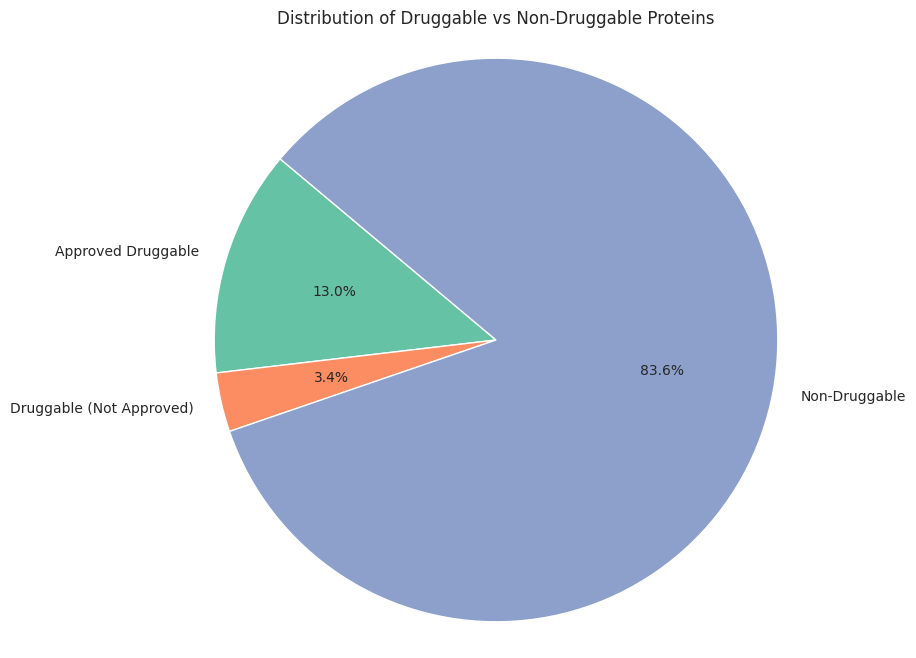

In [ ]:
druggable_counts = properties_df['is_druggable'].value_counts()

druggable_df = properties_df[properties_df['is_druggable'] == 1]
approved_druggable_count = druggable_df['is_approved'].sum()

total_proteins = properties_df.shape[0]

non_druggable_count = total_proteins - druggable_counts[1]
non_approved_druggable_count = druggable_counts[1] - approved_druggable_count

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([approved_druggable_count, non_approved_druggable_count, non_druggable_count], labels=['Approved Druggable', 'Druggable (Not Approved)', 'Non-Druggable'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62', '#8da0cb'])
plt.title('Distribution of Druggable vs Non-Druggable Proteins')
plt.axis('equal')
plt.show()

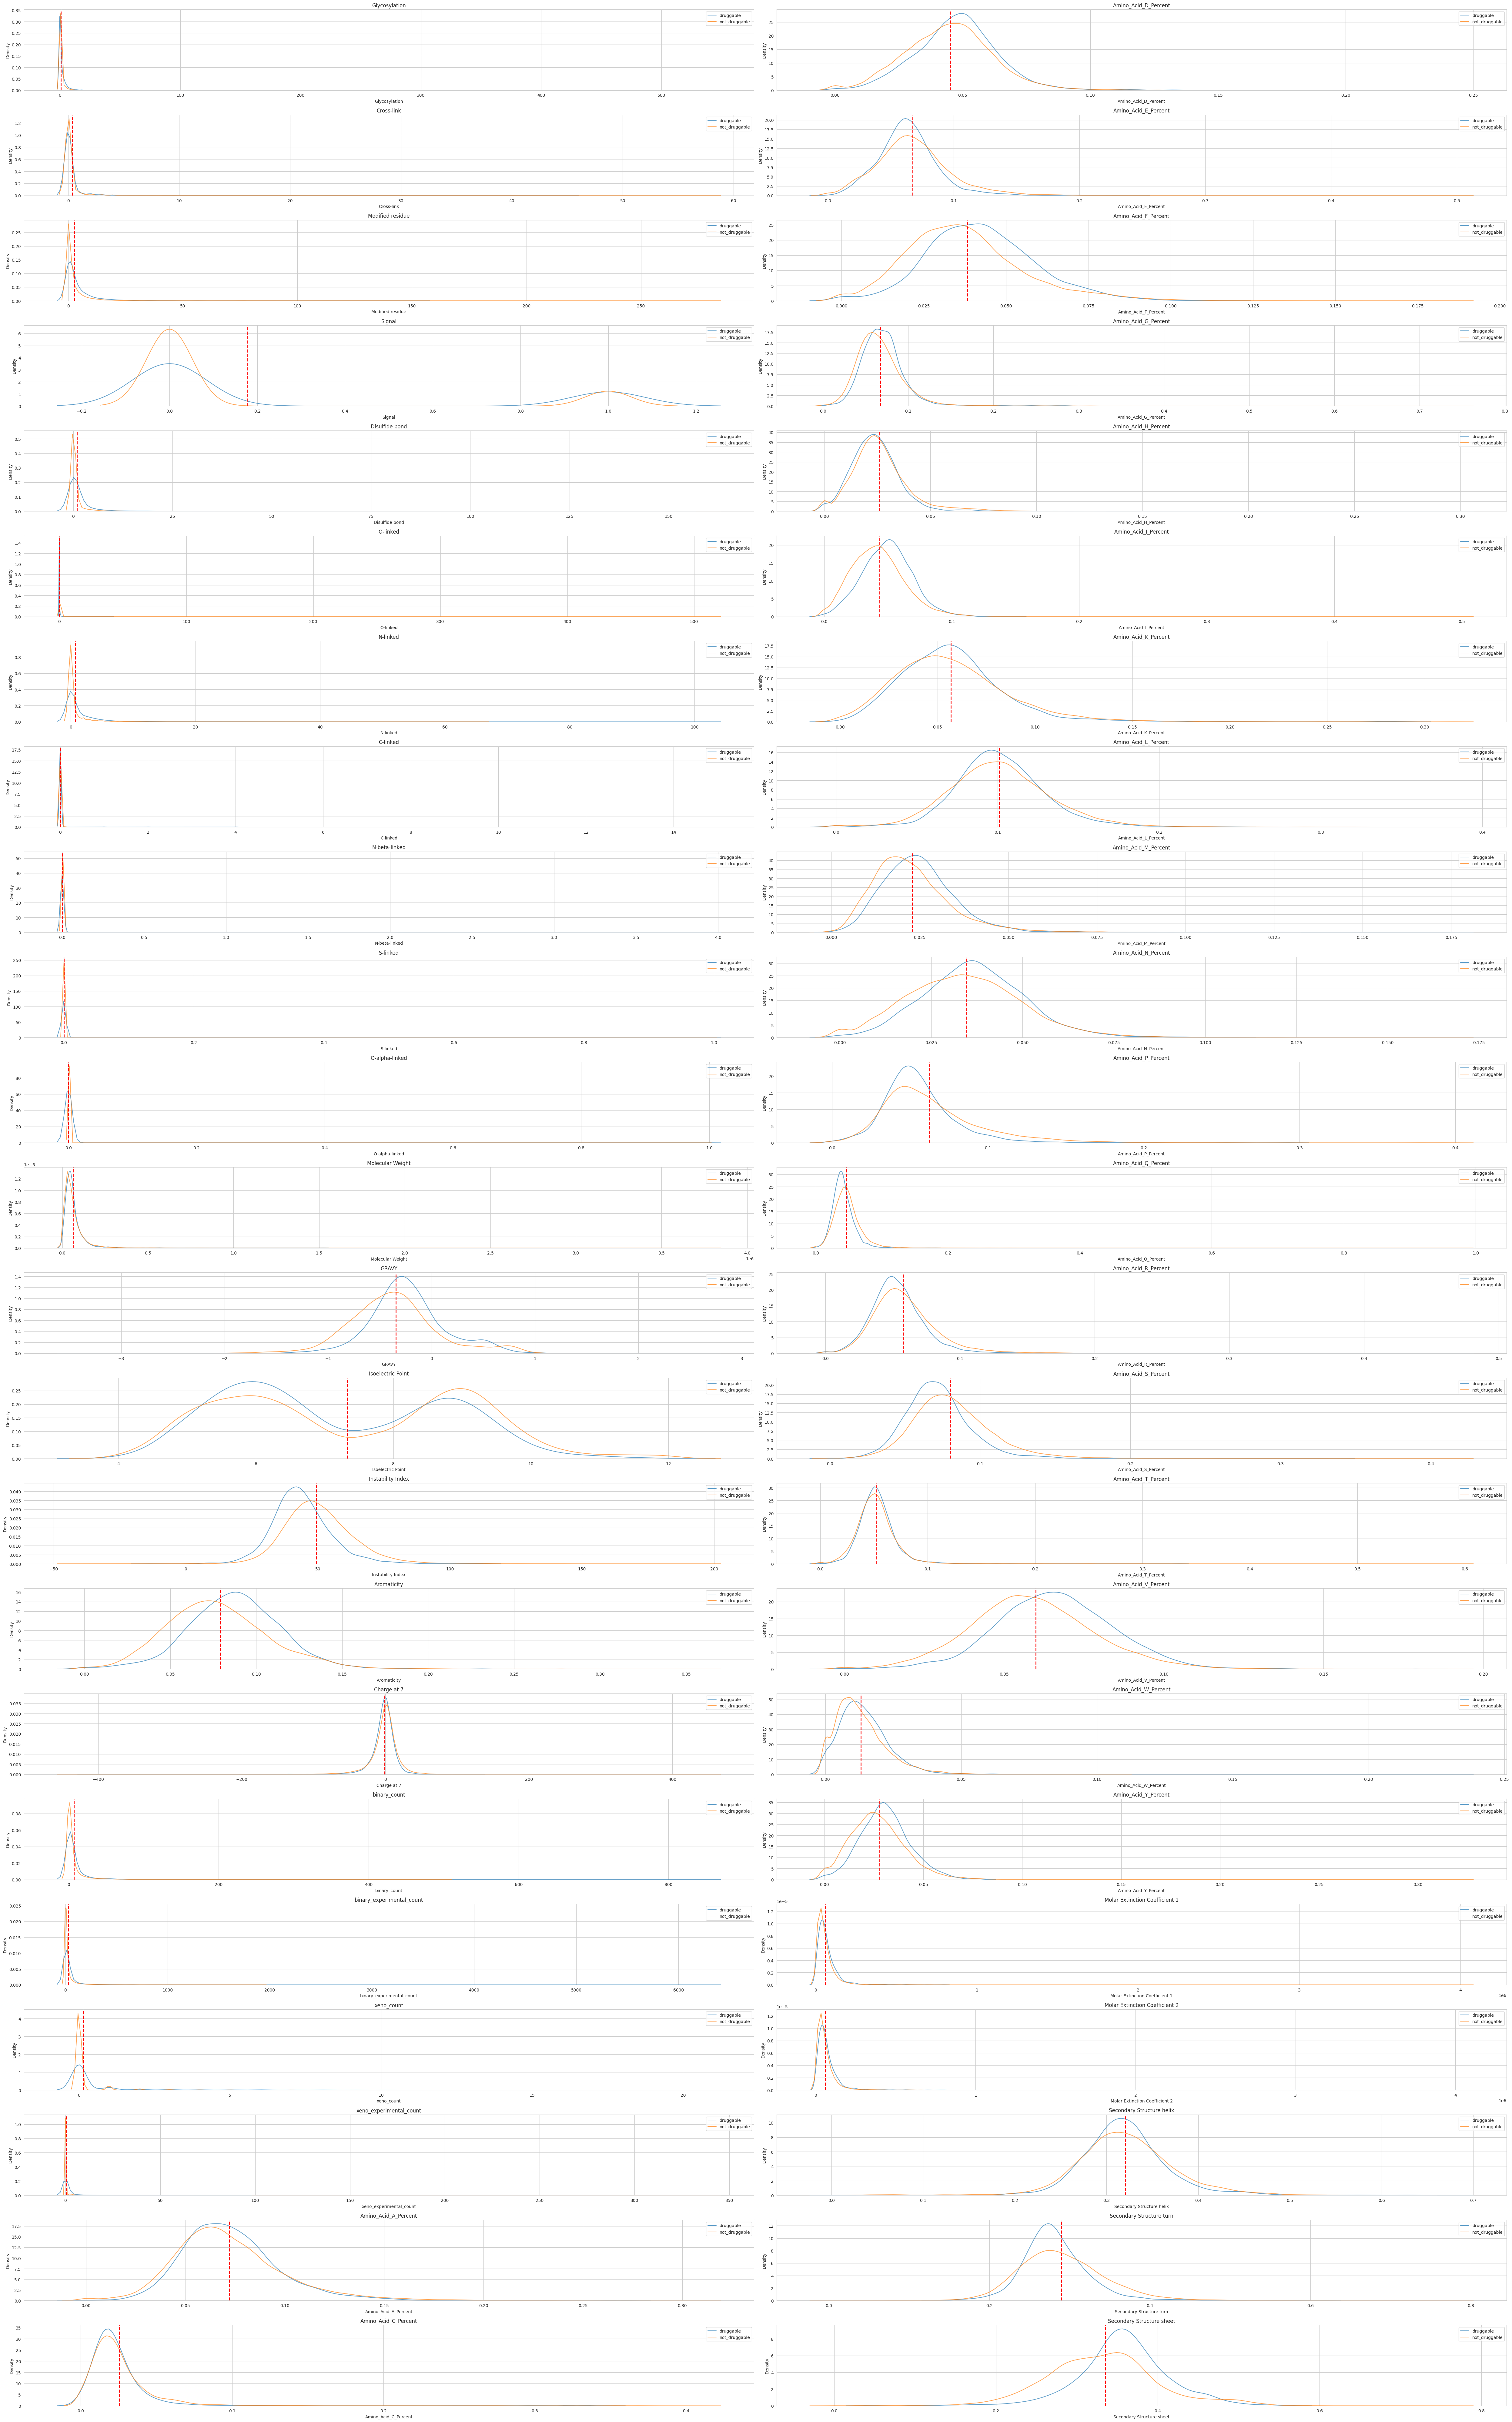

In [ ]:
fig,ax = plt.subplots(figsize = (50,80),nrows = 23,ncols = 2)
okk = [i for i in data.columns if i!= "is_druggable" and i!= "is_approved" and i not in unique_groups_list]
for i,values in enumerate(okk):
  if i <23:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
    ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i][0].set_title(values)
    ax[i][0].legend()
  else:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-23][1],alpha = 0.7,common_norm = True,label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-23][1],alpha = 0.7,common_norm = True,label ='not_druggable')
    ax[i-23][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i-23][1].set_title(values)
    ax[i-23][1].legend()

plt.tight_layout()
plt.show()

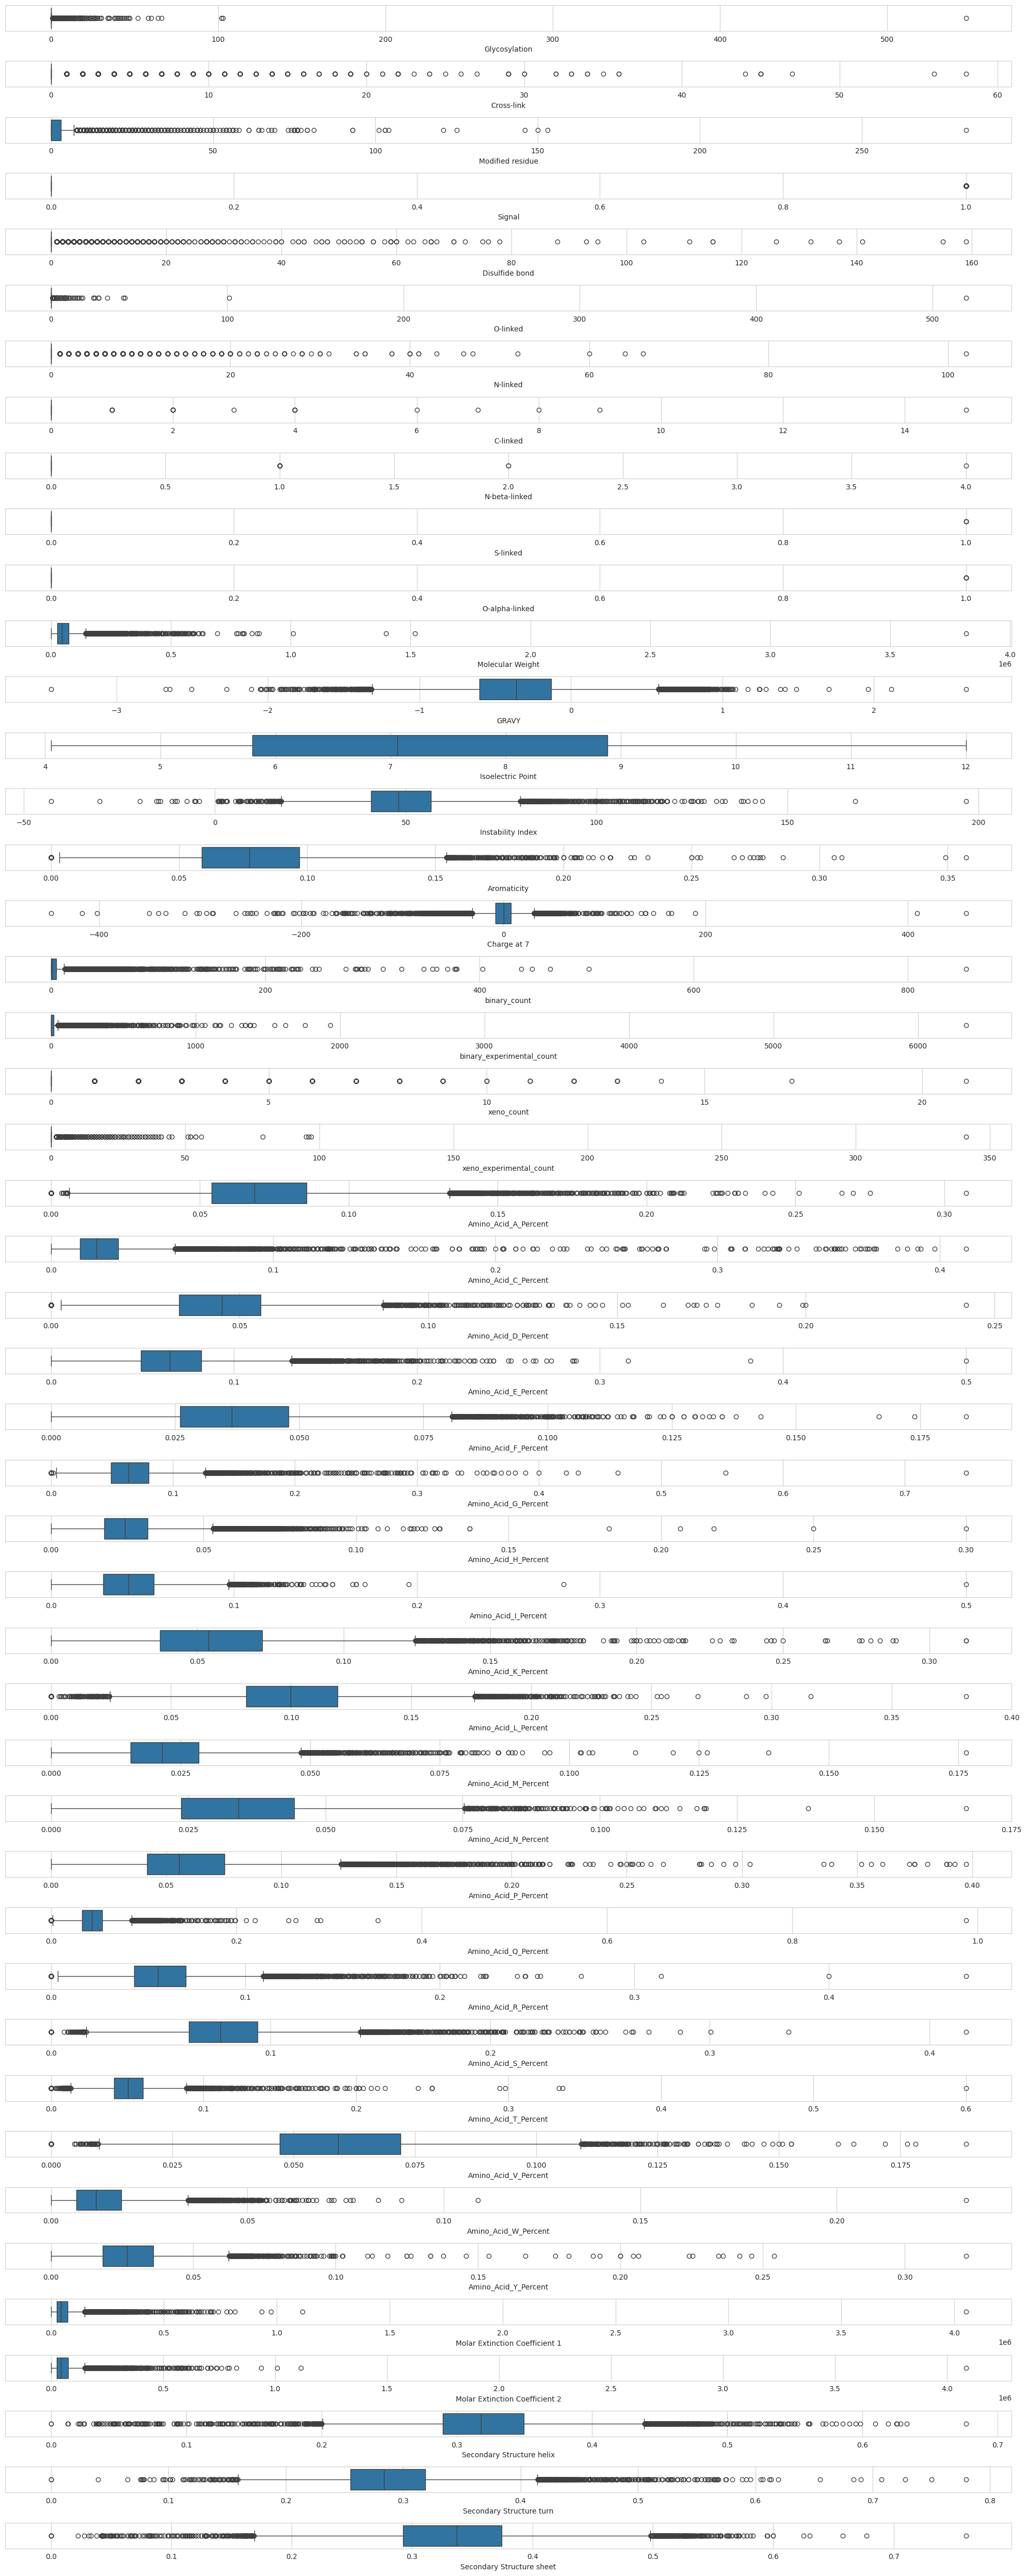

In [ ]:
fig,ax = plt.subplots(figsize = (20,50), nrows = 46 )
for i,values in enumerate(okk):
  sns.boxplot(data[values], orient = 'h',ax = ax[i])
plt.tight_layout()
plt.show()

In [ ]:
#scaling of data on same scale for further analysis(Z-score normalization)
std_scale = StandardScaler()
data[okk] = std_scale.fit_transform(data[okk])
data

Glycosylation  Cross-link  Modified residue    Signal  \
A0A087X1C5       0.023387   -0.174885         -0.392823 -0.463378   
A0A0B4J2F0      -0.183671   -0.174885         -0.392823 -0.463378   
A0A0B4J2F2      -0.183671   -0.174885         -0.392823 -0.463378   
A0A0C5B5G6      -0.183671   -0.174885         -0.392823 -0.463378   
A0A0K2S4Q6       0.023387   -0.174885         -0.392823  2.158067   
...                   ...         ...               ...       ...   
Q9UI54          -0.183671   -0.174885         -0.392823 -0.463378   
Q9UI72          -0.183671   -0.174885         -0.392823 -0.463378   
Q9Y3F1          -0.183671   -0.174885         -0.392823 -0.463378   
Q9Y6C7          -0.183671   -0.174885         -0.392823 -0.463378   
Q9Y6Z2          -0.183671   -0.174885         -0.392823 -0.463378   

            Disulfide bond  O-linked  N-linked  C-linked  N-beta-linked  \
A0A087X1C5       -0.188043  -0.02435  0.079121 -0.023508       -0.01979   
A0A0B4J2F0       -0.188043  -0.02435 -0.297220 -0.023508       -0.01979   
A0A0B4J2F2       -0.188043  -0.02435 -0.297220 -0.023508       -0.01979   
A0A0C5B5G6       -0.188043  -0.02435 -0.297220 -0.023508       -0.01979   
A0A0K2S4Q6        0.021026  -0.02435  0.079121 -0.023508       -0.01979   
...                    ...       ...       ...       ...            ...   
Q9UI54           -0.188043  -0.02435 -0.297220 -0.023508       -0.01979   
Q9UI72           -0.188043  -0.02435 -0.297220 -0.023508       -0.01979   
Q9Y3F1           -0.188043  -0.02435 -0.297220 -0.023508       -0.01979   
Q9Y6C7           -0.188043  -0.02435 -0.297220 -0.023508       -0.01979   
Q9Y6Z2           -0.188043  -0.02435 -0.297220 -0.023508       -0.01979   

            S-linked  ...  Amino_Acid_S_Percent  Amino_Acid_T_Percent  \
A0A087X1C5 -0.012118  ...             -1.171771             -0.179286   
A0A0B4J2F0 -0.012118  ...             -1.597110             -0.801374   
A0A0B4J2F2 -0.012118  ...              0.196830              0.027182   
A0A0C5B5G6 -0.012118  ...             -2.966169             -2.803717   
A0A0K2S4Q6 -0.012118  ...              0.711900              1.768799   
...              ...  ...                   ...                   ...   
Q9UI54     -0.012118  ...              1.066333              3.094095   
Q9UI72     -0.012118  ...             -1.894731             -0.453140   
Q9Y3F1     -0.012118  ...              2.314488              2.988777   
Q9Y6C7     -0.012118  ...              0.179754              0.647130   
Q9Y6Z2     -0.012118  ...              0.924841              0.990197   

            Amino_Acid_V_Percent  Amino_Acid_W_Percent  Amino_Acid_Y_Percent  \
A0A087X1C5              1.300386              0.047635             -1.071593   
A0A0B4J2F0              0.721231             -1.394374              0.603738   
A0A0B4J2F2             -0.320287             -0.581419             -0.491929   
A0A0C5B5G6             -3.054272              5.236294              6.408663   
A0A0K2S4Q6              1.002985              1.244698             -0.527151   
...                          ...                   ...                   ...   
Q9UI54                 -0.274129             -1.394374              0.559298   
Q9UI72                 -2.315587              1.680718              1.028813   
Q9Y3F1                 -2.144106              2.394579              1.694889   
Q9Y6C7                 -1.427593              3.120123             -0.436338   
Q9Y6Z2                 -0.371678              0.466866              0.475097   

            Molar Extinction Coefficient 1  Molar Extinction Coefficient 2  \
A0A087X1C5                       -0.182244                       -0.184374   
A0A0B4J2F0                       -0.860544                       -0.862924   
A0A0B4J2F2                       -0.038834                       -0.033074   
A0A0C5B5G6                       -0.776634                       -0.779916   
A0A0K2S4Q6                       -0.395529            

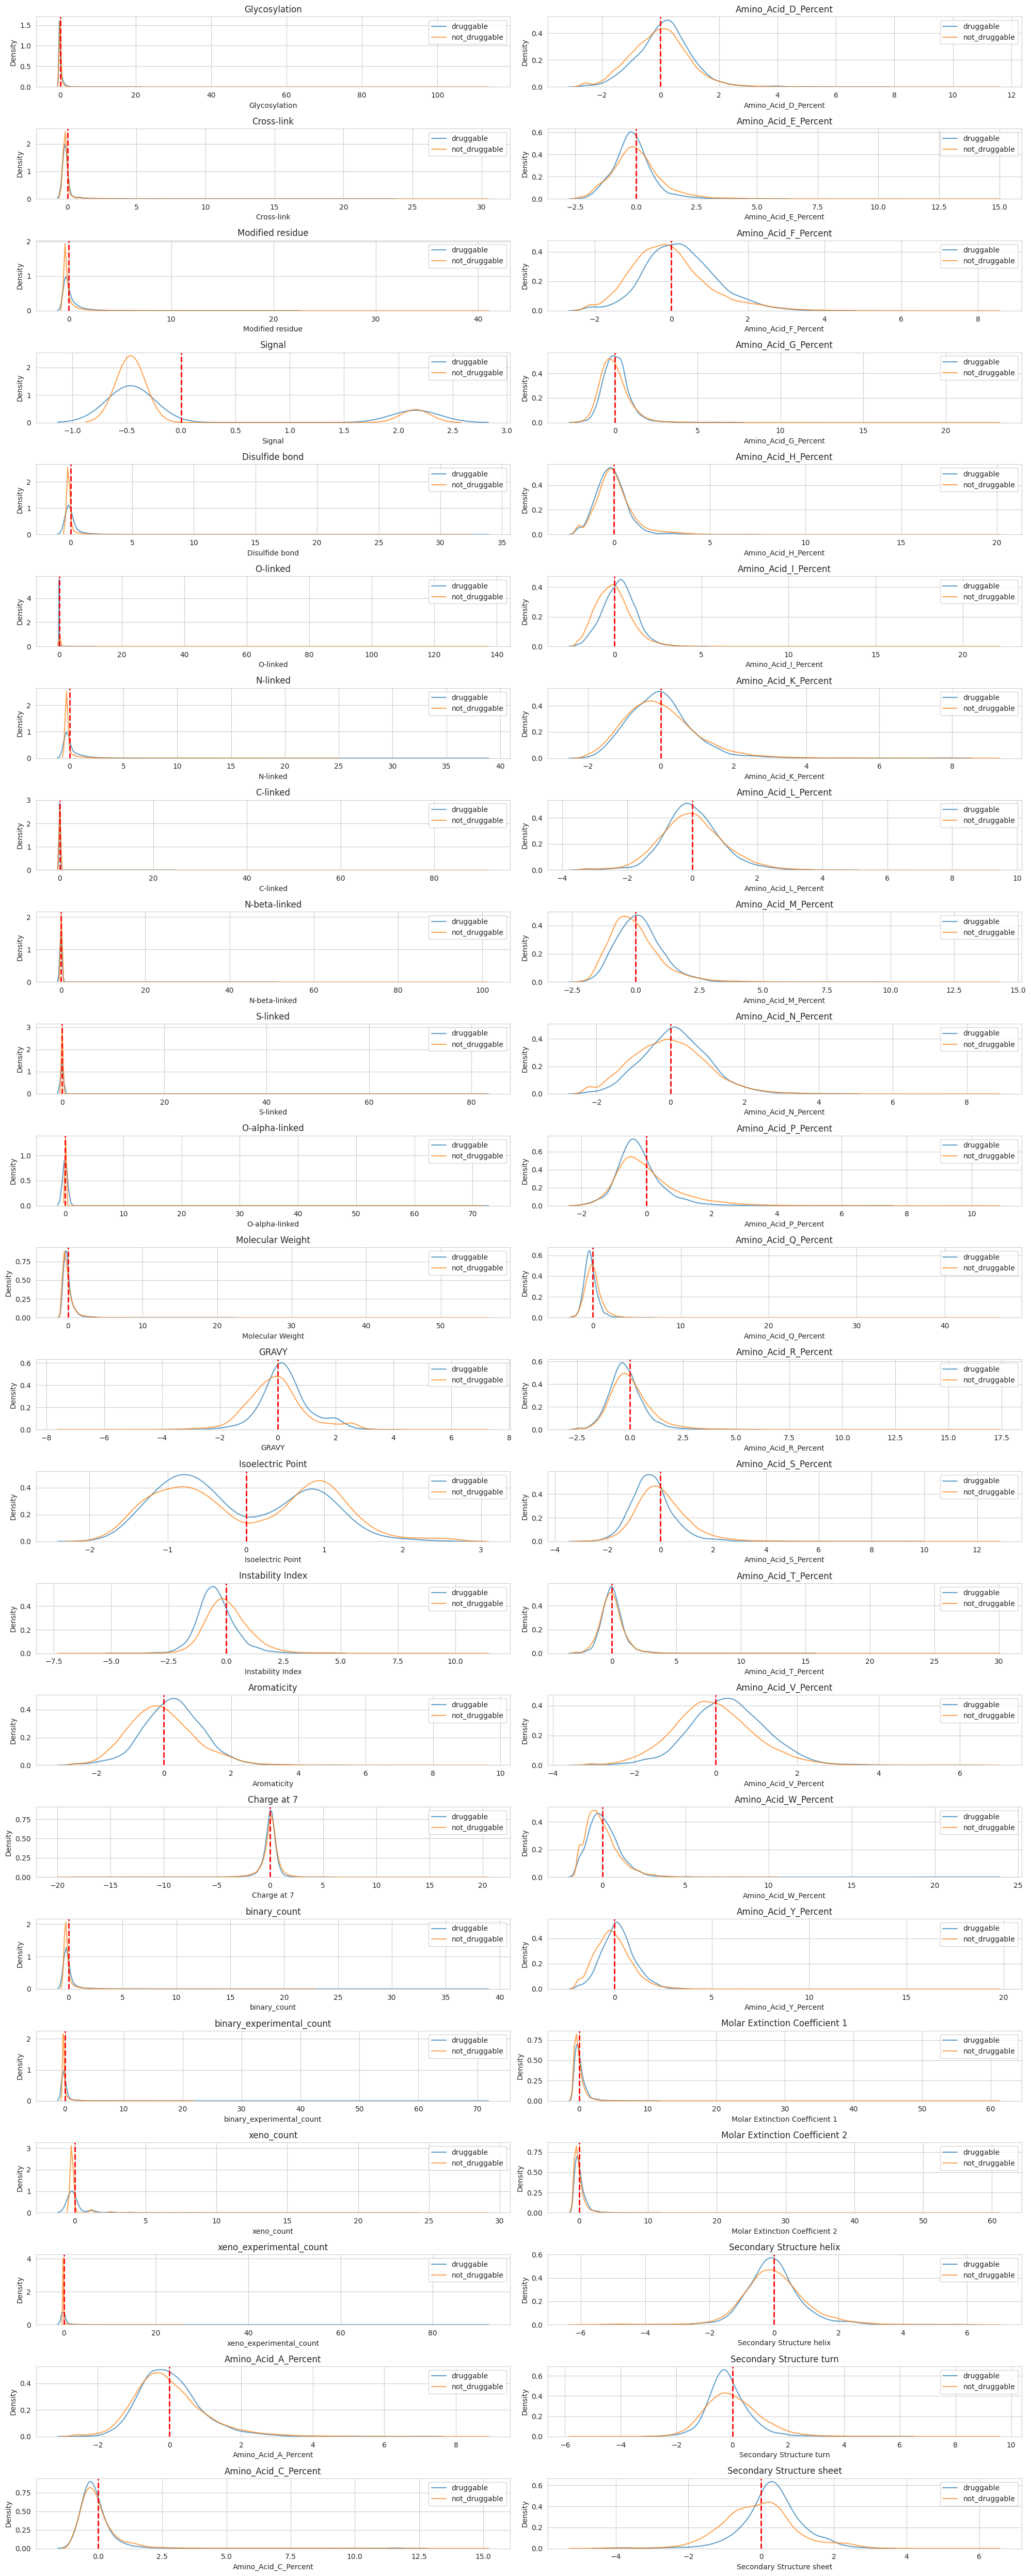

In [ ]:
fig,ax = plt.subplots(figsize = (20,50),nrows = 23,ncols = 2)
for i,values in enumerate(okk):
  if i <23:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label = 'druggable')
    sns.kdeplot(data = data[data['is_druggable'] == 0], x=values, ax=ax[i][0],alpha = 0.7,common_norm = True, label ='not_druggable')
    ax[i][0].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i][0].set_title(values)
    ax[i][0].legend()
  else:
    sns.kdeplot(data=data[data['is_druggable'] == 1], x=values, ax=ax[i-23][1],alpha = 0.7,common_norm = True,label = 'druggable')
    sns.kdeplot(data=data[data['is_druggable'] == 0], x=values, ax=ax[i-23][1],alpha = 0.7,common_norm = True,label ='not_druggable')
    ax[i-23][1].axvline(data[values].mean(), color='red', linestyle='dashed', linewidth=2)
    ax[i-23][1].set_title(values)
    ax[i-23][1].legend()

plt.tight_layout()
plt.show()

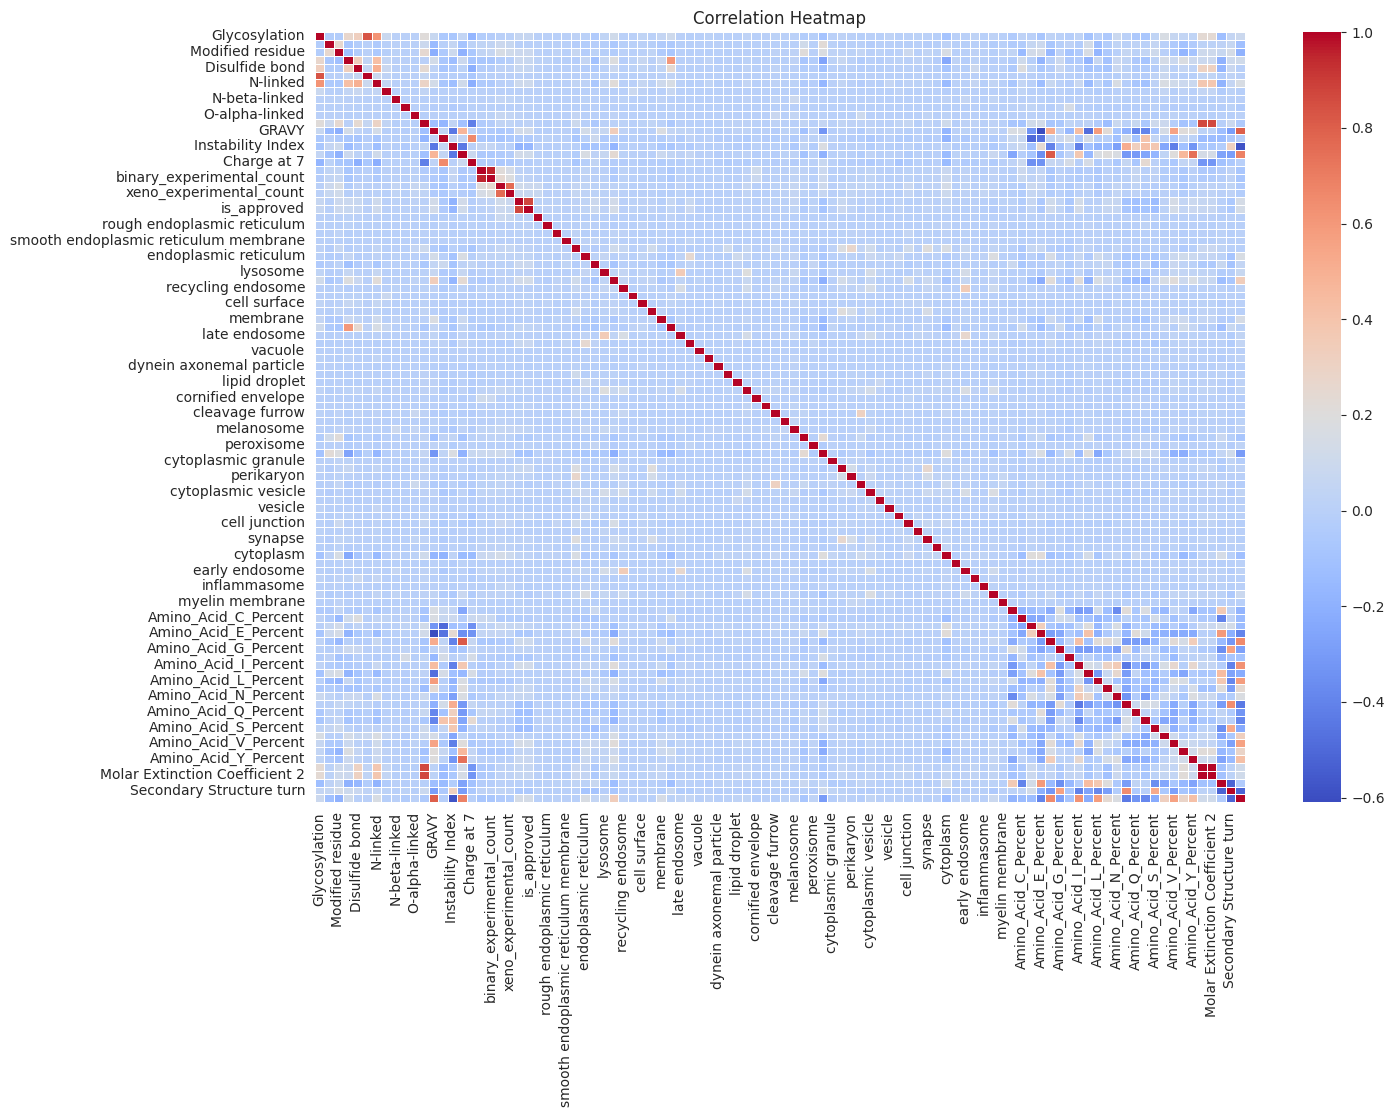

In [ ]:
okk_1 = data.copy()
plt.figure(figsize=(15, 10))
sns.heatmap(okk_1.corr(), cmap='coolwarm', annot=False, fmt=".2f",linewidth= 0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
location_data = okk_1.iloc[:,23:73]

n_components = 50
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(location_data)
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': location_data.columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

In [ ]:
pca_report

n                 model       var
0    1   PCA(n_components=1)  0.226203
1    2   PCA(n_components=2)  0.376415
2    3   PCA(n_components=3)  0.496187
3    4   PCA(n_components=4)  0.574364
4    5   PCA(n_components=5)  0.640044
5    6   PCA(n_components=6)  0.695342
6    7   PCA(n_components=7)  0.740981
7    8   PCA(n_components=8)  0.781724
8    9   PCA(n_components=9)  0.817686
9   10  PCA(n_components=10)  0.844354
10  11  PCA(n_components=11)  0.866762
11  12  PCA(n_components=12)  0.884967
12  13  PCA(n_components=13)  0.899814
13  14  PCA(n_components=14)  0.911765
14  15  PCA(n_components=15)  0.923300
15  16  PCA(n_components=16)  0.933283
16  17  PCA(n_components=17)  0.940564
17  18  PCA(n_components=18)  0.946204
18  19  PCA(n_components=19)  0.950995
19  20  PCA(n_components=20)  0.955658
20  21  PCA(n_components=21)  0.960078
21  22  PCA(n_components=22)  0.964360
22  23  PCA(n_components=23)  0.968517
23  24  PCA(n_components=24)  0.972417
24  25  PCA(n_components=25)  0.975949
25  26  PCA(n_components=26)  0.979319
26  27  PCA(n_components=27)  0.982418
27  28  PCA(n_components=28)  0.985075
28  29  PCA(n_components=29)  0.987340
29  30  PCA(n_components=30)  0.989436
30  31  PCA(n_components=31)  0.991086
31  32  PCA(n_components=32)  0.992542
32  33  PCA(n_components=33)  0.993684
33  34  PCA(n_components=34)  0.994727
34  35  PCA(n_components=35)  0.995606
35  36  PCA(n_components=36)  0.996264
36  37  PCA(n_components=37)  0.996792
37  38  PCA(n_components=38)  0.997273
38  39  PCA(n_components=39)  0.997714
39  40  PCA(n_components=40)  0.998152
40  41  PCA(n_components=41)  0.998548
41  42  PCA(n_components=42)  0.998943
42  43  PCA(n_components=43)  0.999208
43  44  PCA(n_components=44)  0.999428
44  45  PCA(n_components=45)  0.999648
45  46  PCA(n_components=46)  0.999779
46  47  PCA(n_components=47)  0.999868
47  48  PCA(n_components=48)  0.999912
48  49  PCA(n_components=49)  0.999956

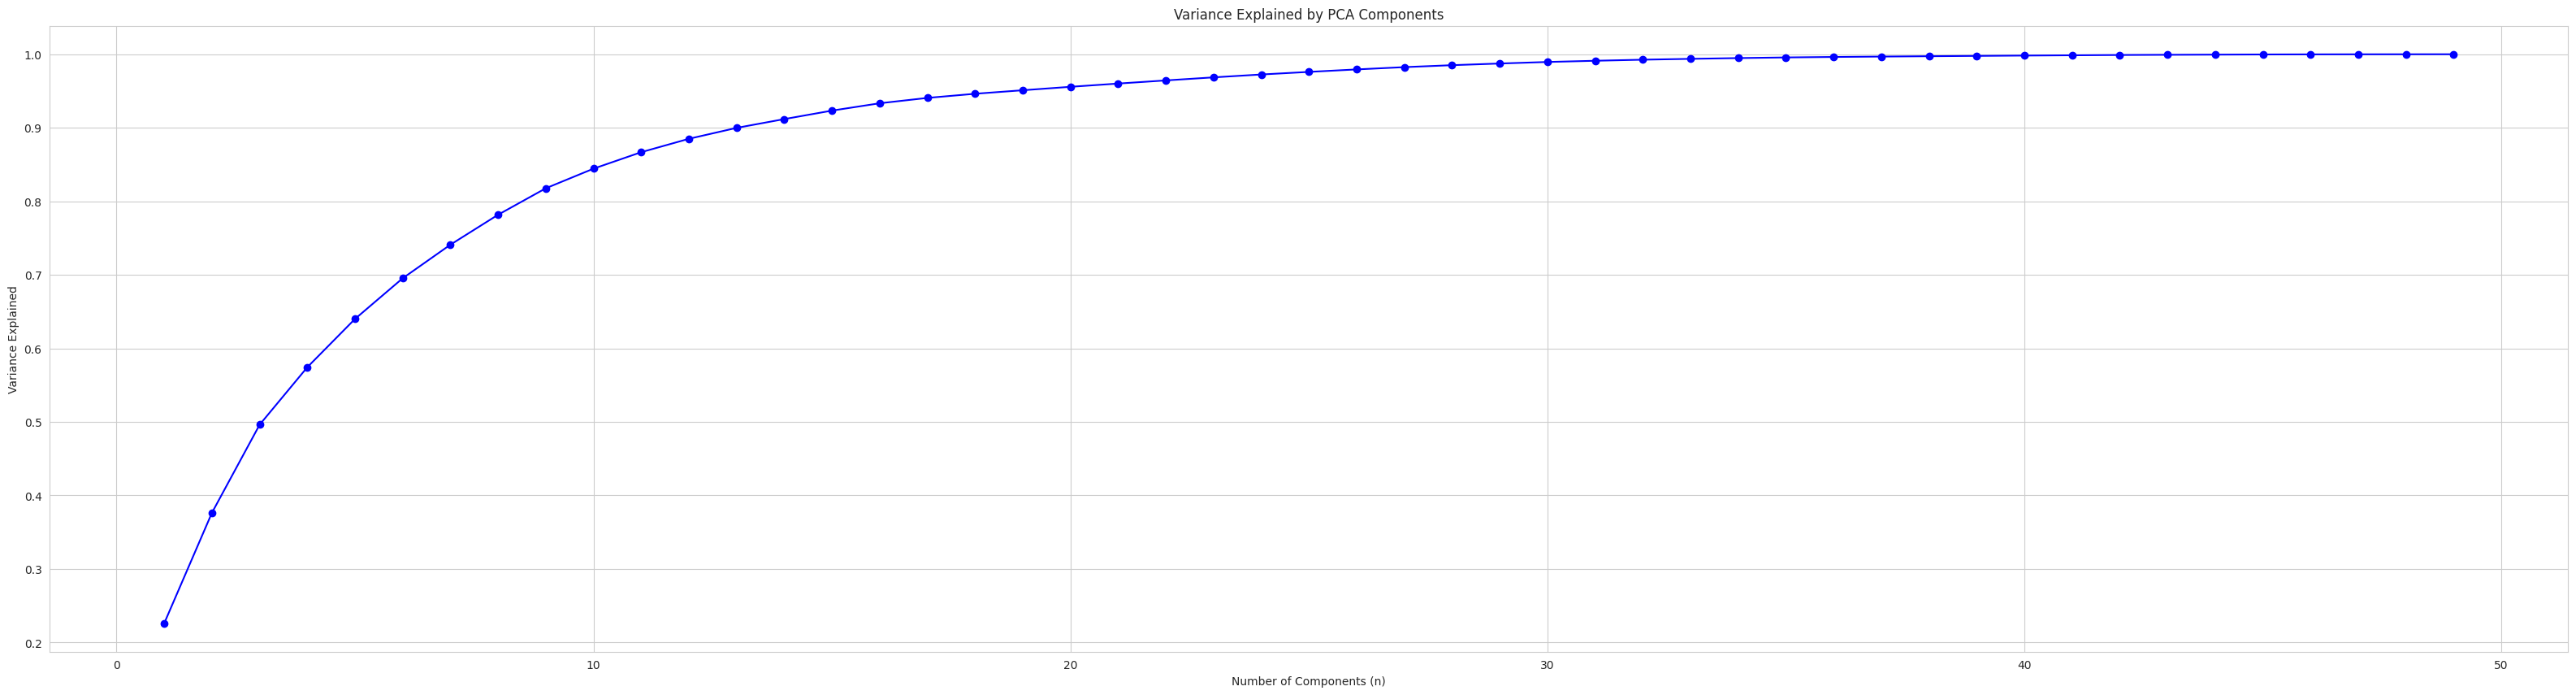

In [ ]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

[Text(0.5, 24.0, 'Number of components'),
 Text(23.999999999999993, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

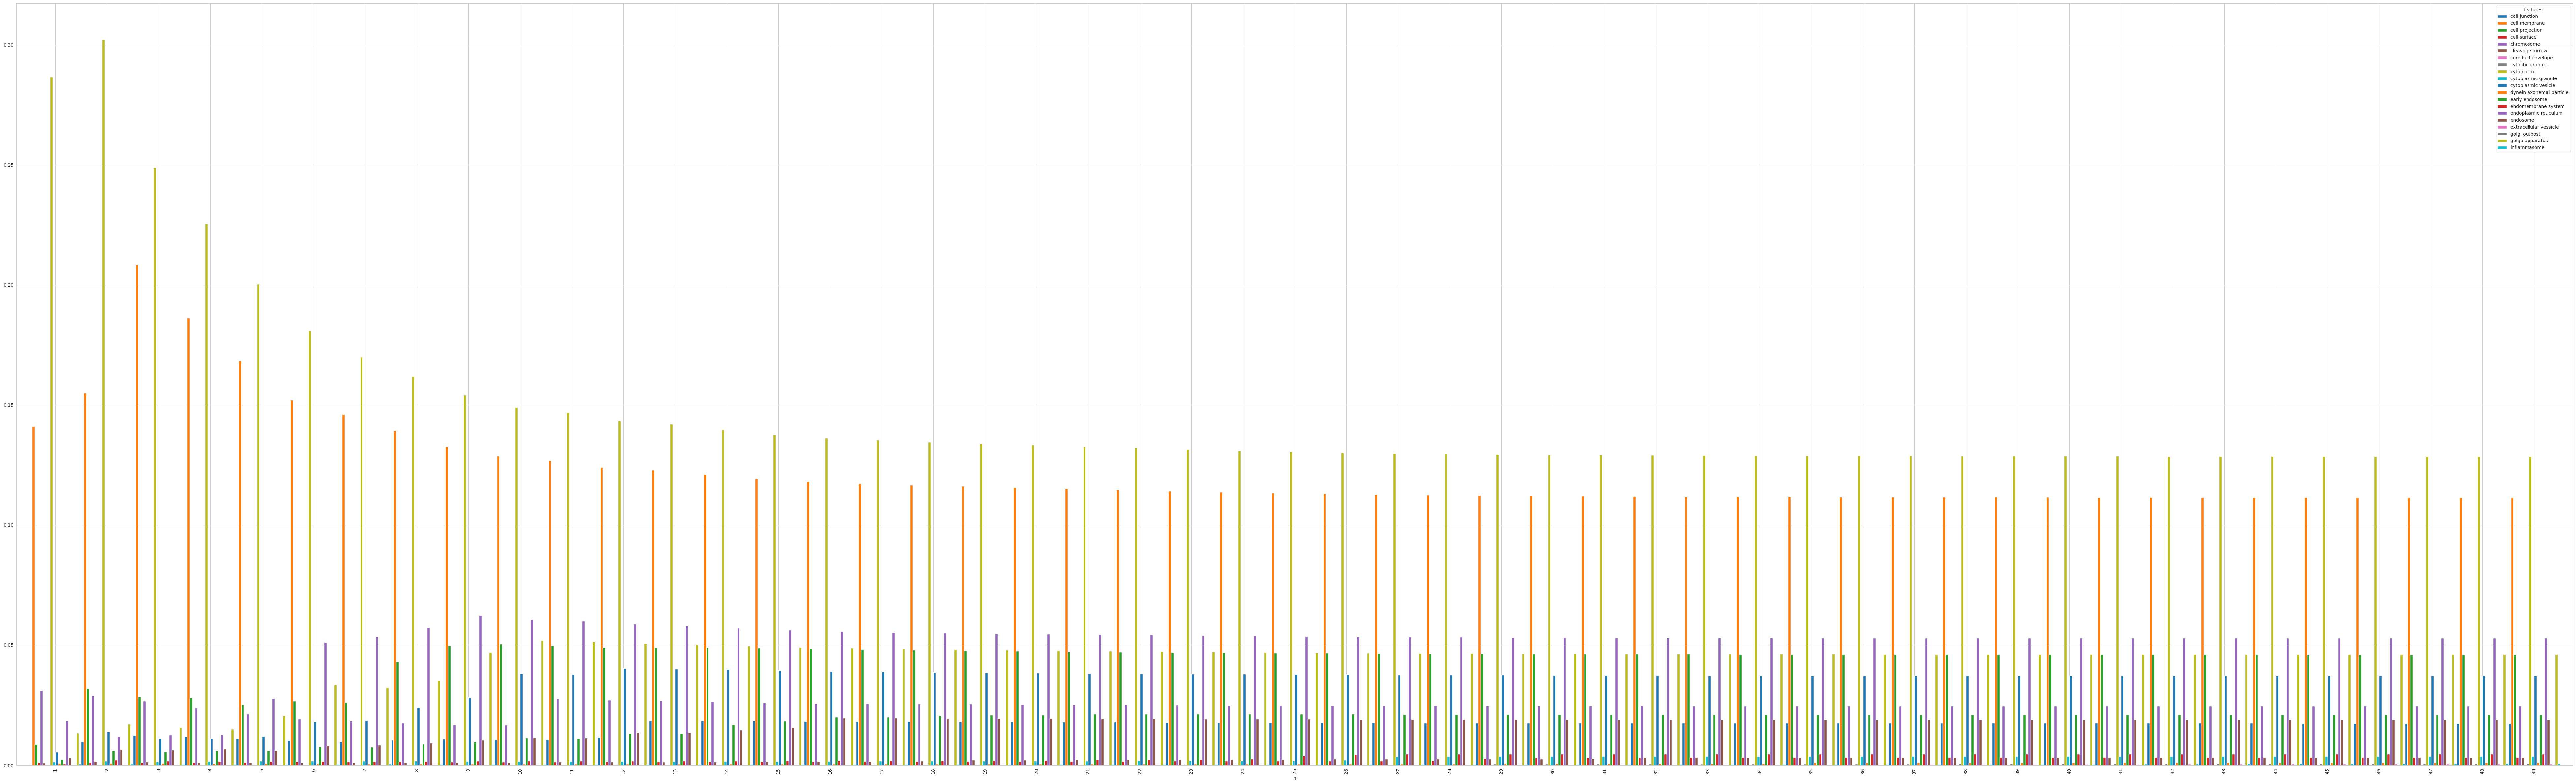

In [ ]:
x = feature_importance_report.iloc[:,:20].plot(kind = 'bar' , figsize = (100,30), width=1)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

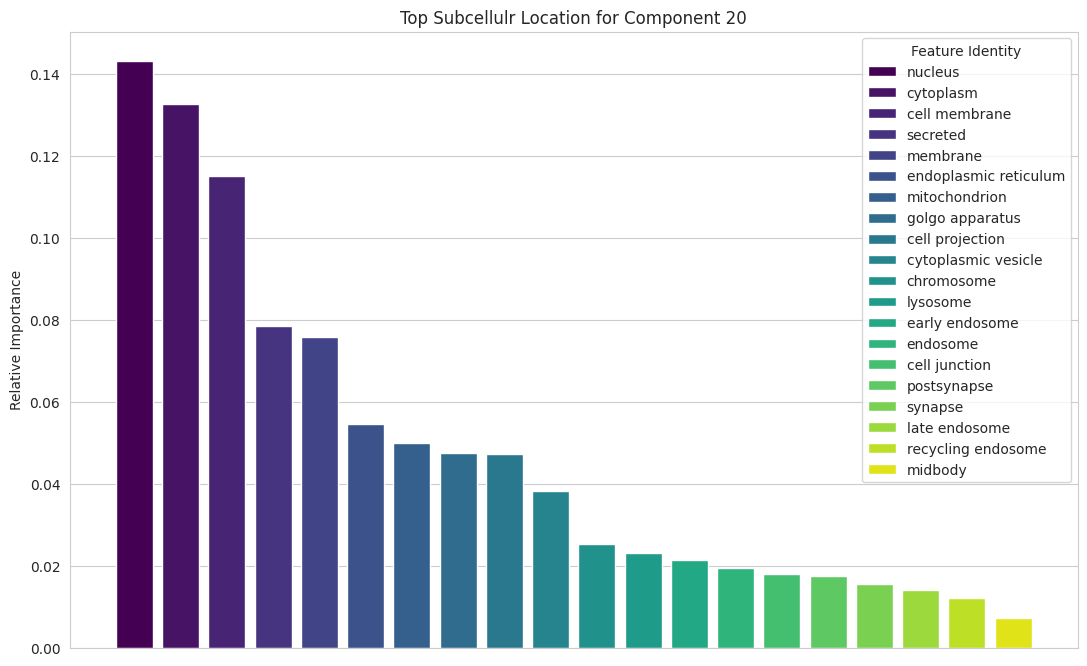

In [ ]:
plt.figure(figsize= (20,12))
n_top_features = 20
top_features = feature_importance_report.iloc[20].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Subcellulr Location for Component 20')
plt.show()

In [ ]:
#PCA Analysis for reduction and selection of relevant ones

n_components = 50
pca_list = []
feature_weight_list = []
for i in range(1,n_components):
  PCAmod = PCA(n_components = i)
  PCAmod.fit(okk_1)
  pca_list.append(pd.Series({
      "n" : i,
      "model" : PCAmod,
      "var" : PCAmod.explained_variance_ratio_.sum(),
  }))
  weights = PCAmod.explained_variance_ratio_.reshape(-1, 1) / PCAmod.explained_variance_ratio_.sum()
  overall_contributions = np.abs(PCAmod.components_) * weights
  abs_feature_values = overall_contributions.sum(axis=0)
  feature_weight_list.append(pd.DataFrame({
      'n': i,
      'features': okk_1.columns,
      'values': abs_feature_values / abs_feature_values.sum(),
  }))
pca_report = pd.DataFrame(pca_list)
feature_importance_report = pd.concat(feature_weight_list).pivot(index='n', columns='features', values='values')

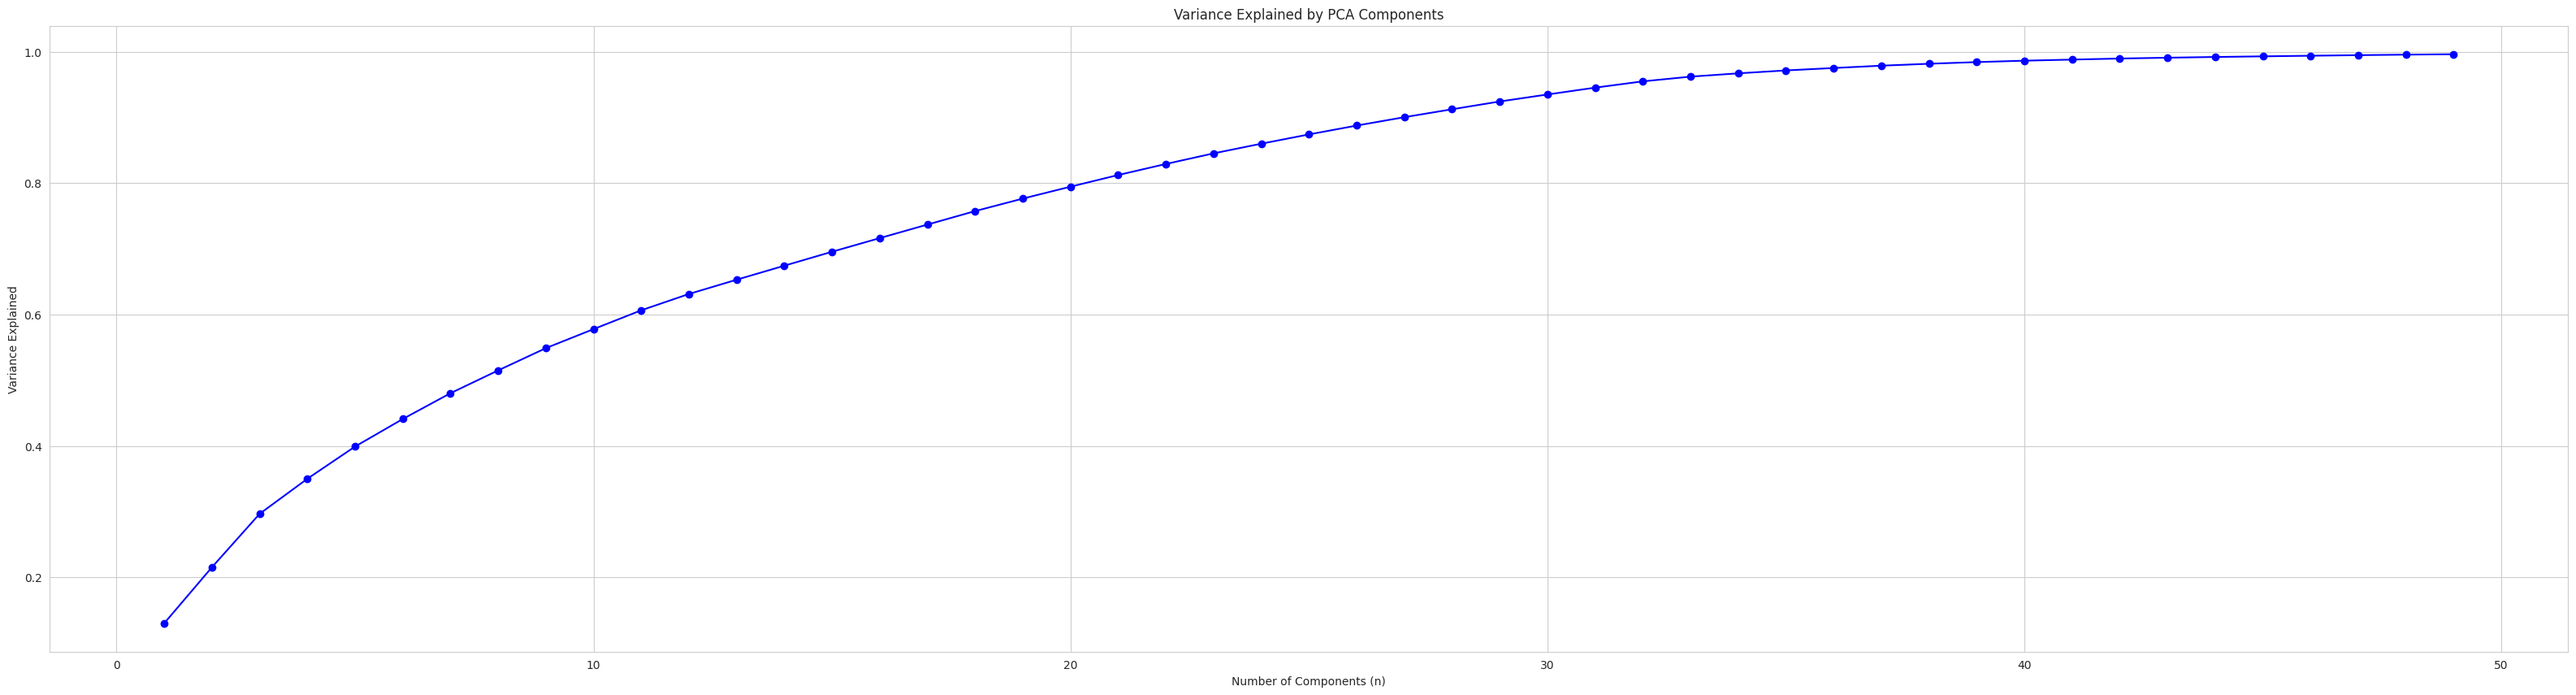

In [ ]:
fig,ax = plt.subplots(figsize = (40,10))
plt.plot(pca_report['n'], pca_report['var'], marker = 'o', linestyle = "-", color = 'b')
plt.title('Variance Explained by PCA Components')
# plt.axvline(x=150, color='r', linestyle='--', linewidth=2, label='Threshold at x=50')
plt.xlabel('Number of Components (n)')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

[Text(0.5, 0, 'Number of components'),
 Text(0, 0.5, 'Relative Importance'),
 Text(0.5, 1.0, 'Feature Importance Vs Dimensions')]

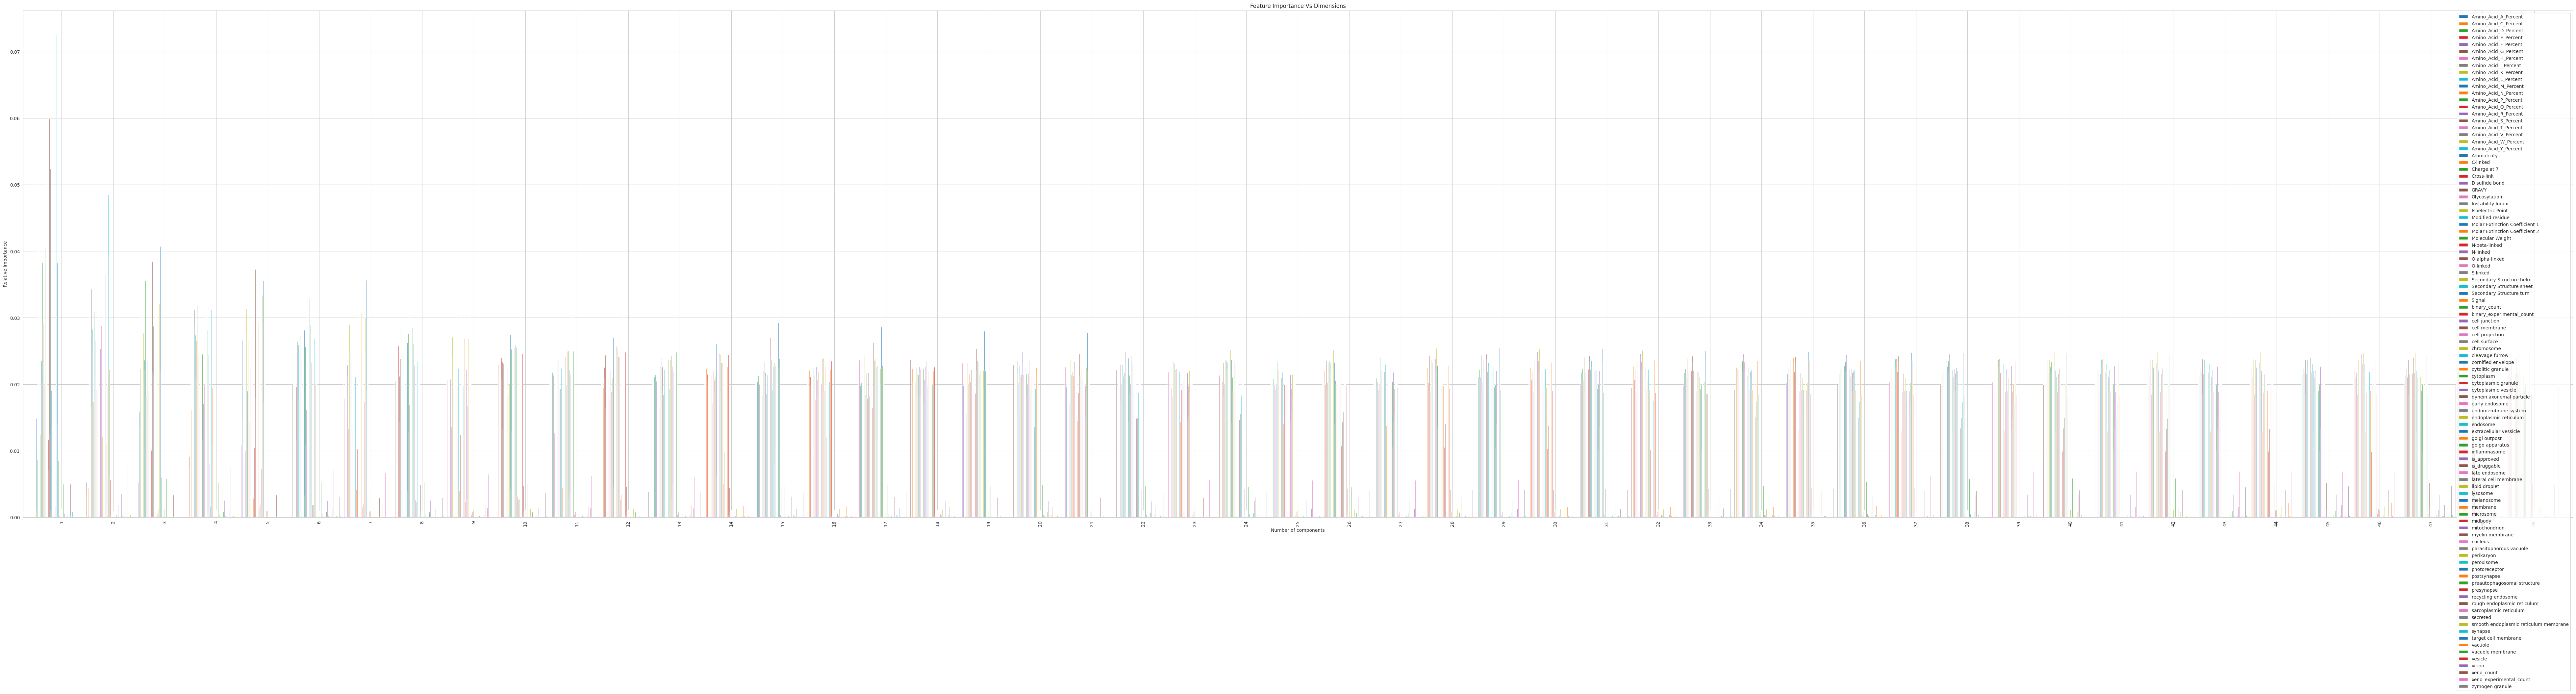

In [ ]:
ax = feature_importance_report.plot(kind = 'bar' , figsize = (100,20), width=1)
ax.legend(loc = 'upper right')
ax.set(xlabel = 'Number of components' ,  ylabel = 'Relative Importance' , title = 'Feature Importance Vs Dimensions')

<Figure size 2000x1200 with 0 Axes>

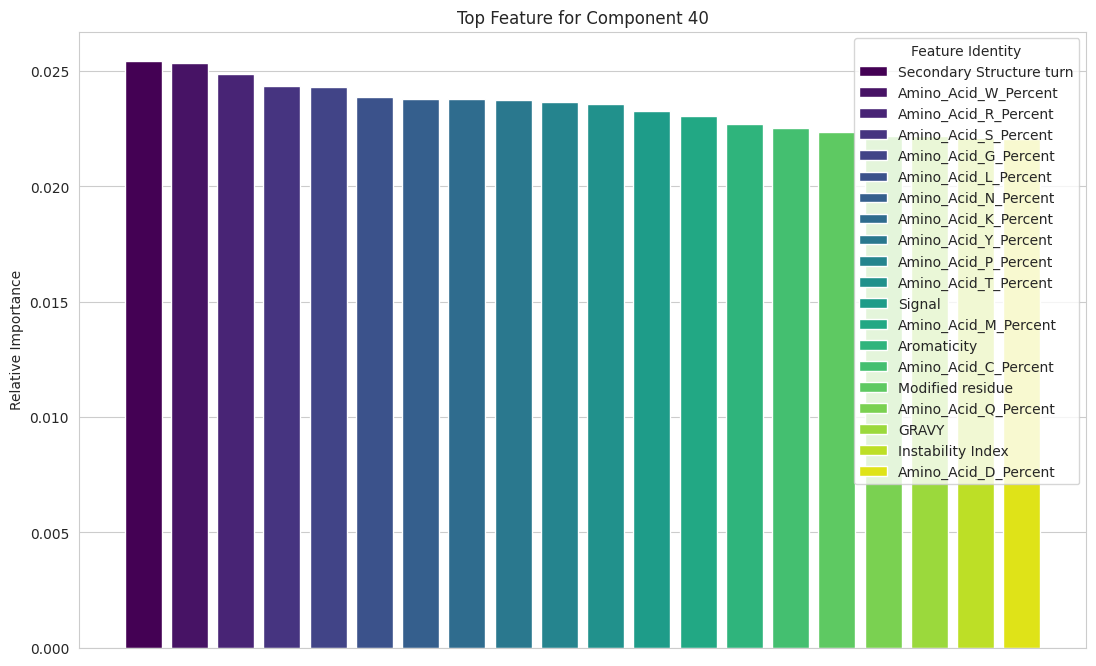

In [ ]:
plt.figure(figsize= (20,12))
n_top_features = 20
top_features = feature_importance_report.iloc[29].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Feature for Component 40')
plt.show()

<Figure size 2000x1200 with 0 Axes>

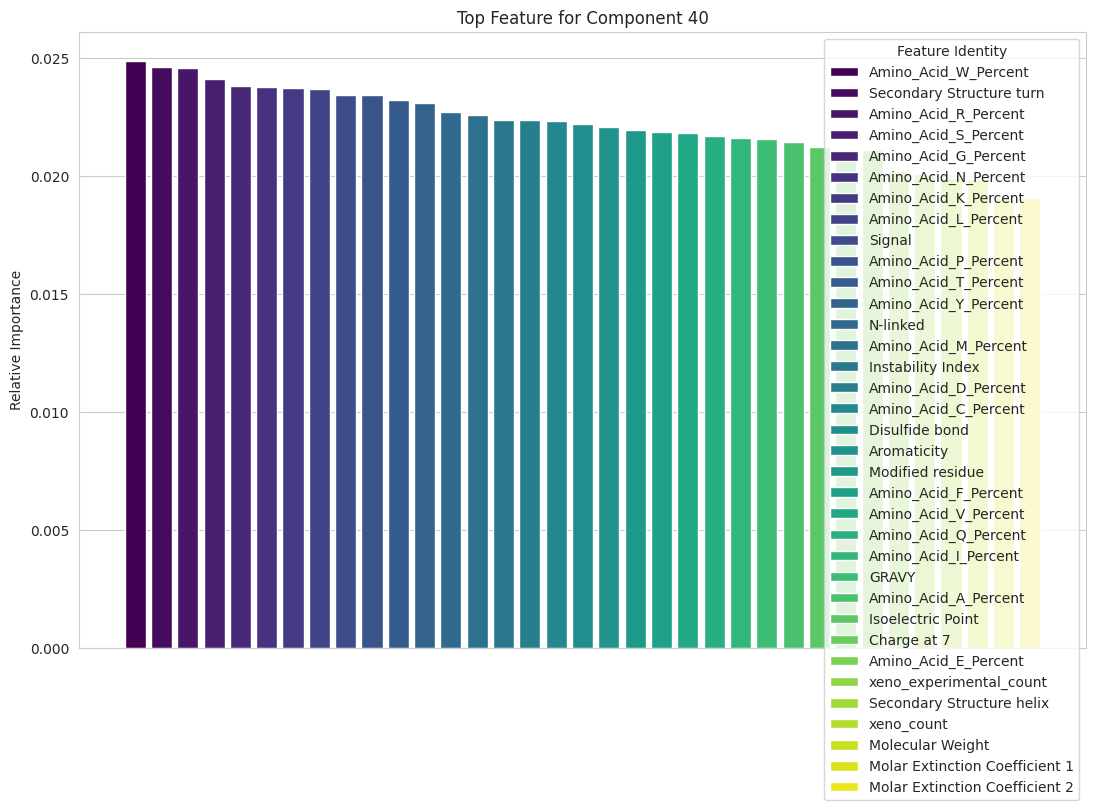

In [ ]:
plt.figure(figsize= (20,12))
n_top_features = 35
top_features = feature_importance_report.iloc[40].nlargest(n_top_features)
fig, ax = plt.subplots(figsize=(13, 8))

for idx, (feature, importance) in enumerate(top_features.items()):
    ax.bar(idx, importance, label=feature, color=plt.cm.viridis(idx / len(top_features)))

ax.set_xticks([])

ax.legend(loc='upper right', title='Feature Identity')

ax.set(ylabel='Relative Importance', title='Top Feature for Component 40')
plt.show()

vacuole membrane                         0.000000
smooth endoplasmic reticulum membrane    0.000000
inflammasome                             0.000000
cell surface                             0.000000
presynapse                               0.000000
                                           ...   
golgo apparatus                          0.031051
Disulfide bond                           0.032734
cell membrane                            0.041461
microsome                                0.044030
Modified residue                         0.053035
Length: 96, dtype: float32


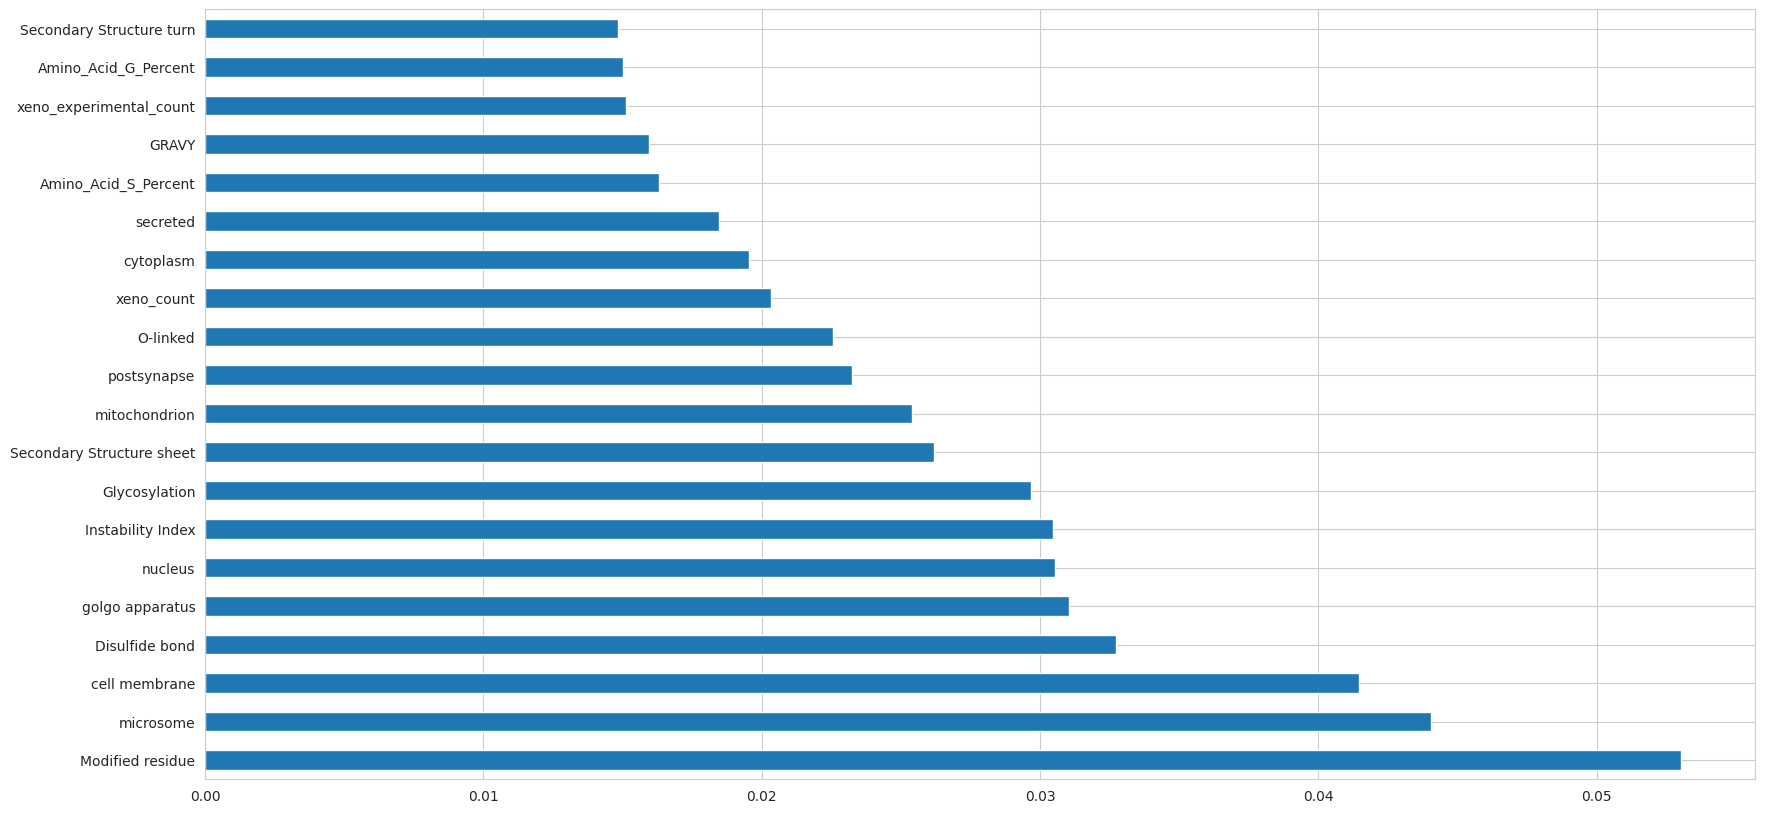

In [ ]:
#lets see each feature importance using XGB Classifier
okk_1 = okk_1.drop(columns = ['is_approved'])
import xgboost

x_sample = okk_1.drop(columns = ['is_druggable'])
y_sample = okk_1['is_druggable']

model = xgboost.XGBClassifier()
model.fit(x_sample,y_sample)

feat_imp = pd.Series(model.feature_importances_, index=x_sample.columns)
print(feat_imp.sort_values())
feat_imp.nlargest(20).plot(kind='barh',figsize=(20,10))

plt.show()

In [ ]:
druggable_indices = (y_sample == 1)  # Assuming 1 represents druggable
non_druggable_indices = (y_sample == 0)  # Assuming 0 represents non-druggable

druggable_X = x_sample[druggable_indices]
druggable_y = y_sample[druggable_indices]

non_druggable_X = x_sample[non_druggable_indices]
non_druggable_y = y_sample[non_druggable_indices]

In [ ]:
class_size = 1000
druggable_X_remaining, druggable_X_test, druggable_y_remaining, druggable_y_test = train_test_split(druggable_X, druggable_y, test_size=class_size, random_state=123)
non_druggable_X_remaining, non_druggable_X_test, non_druggable_y_remaining, non_druggable_y_test = train_test_split(non_druggable_X, non_druggable_y, test_size=class_size, random_state=123)

In [ ]:
X_test = pd.concat((druggable_X_test, non_druggable_X_test))
y_test = pd.concat((druggable_y_test, non_druggable_y_test))

X_train = pd.concat((druggable_X_remaining, non_druggable_X_remaining))
y_train = pd.concat((druggable_y_remaining, non_druggable_y_remaining))

In [ ]:
#model building
sc = StandardScaler()
oversample = SMOTE()
X_train,y_train = oversample.fit_resample(X_train,y_train)

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#using xgboost boosting algorithms
model_1 = xgboost.XGBClassifier()
model_1.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
from sklearn.model_selection import cross_validate

def test_results(model, k):
  results = {}
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']
  okk = cross_validate(model, X_test, y_test, cv=k, scoring=scoring)

  for metric in scoring:
    mean_score = np.mean(okk['test_' + metric])
    results[metric] = mean_score


  return results

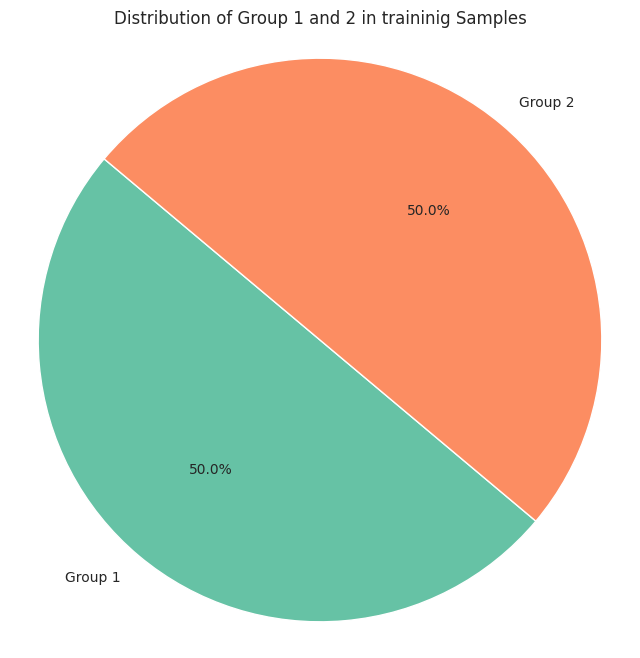

In [ ]:
group_counts = pd.Series(y_train).value_counts()
group1_count = group_counts[1]
group2_count = group_counts[0]

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([group1_count, group2_count], labels=['Group 1', 'Group 2'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Group 1 and 2 in traininig Samples')
plt.axis('equal')
plt.show()

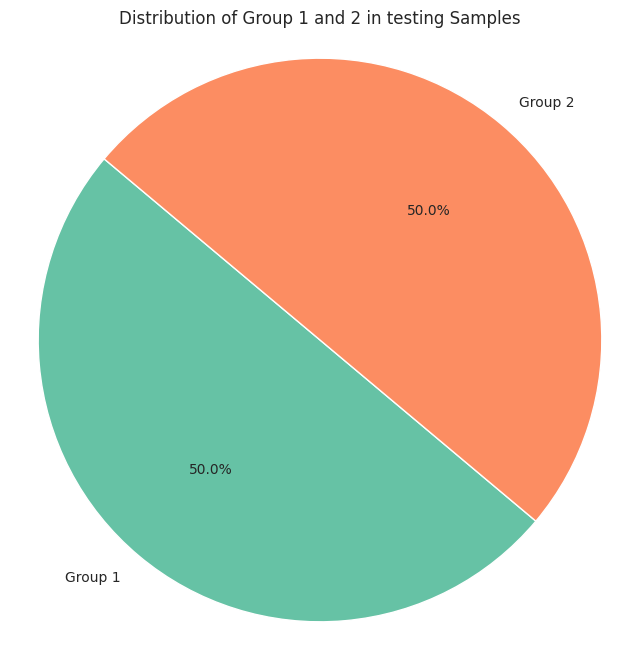

In [ ]:
group_counts = pd.Series(y_test).value_counts()
group1_count = group_counts[1]
group2_count = group_counts[0]

# Plotting
plt.figure(figsize=(8, 8))
plt.pie([group1_count, group2_count], labels=['Group 1', 'Group 2'], autopct='%1.1f%%', startangle=140, colors=['#66c2a5', '#fc8d62'])
plt.title('Distribution of Group 1 and 2 in testing Samples')
plt.axis('equal')
plt.show()

In [ ]:
y_pred = model_1.predict(X_test)
metrics_1 = test_results(model_1, 5)

In [ ]:
metrics_1

{'accuracy': 0.7646666666666666,
 'precision_weighted': 0.7574764578960997,
 'recall_weighted': 0.7646666666666666,
 'f1_weighted': 0.7573173130023222}

In [ ]:
#using logistic regression algorithm
model_2 = LogisticRegression(max_iter = 1000)
model_2.fit(X_train,y_train)

LogisticRegression(max_iter=1000)

In [ ]:
y_pred_2 = model_2.predict(X_test)
metrics_2= test_results(model_2, 5)
metrics_2

{'accuracy': 0.71,
 'precision_weighted': 0.6947858021990132,
 'recall_weighted': 0.71,
 'f1_weighted': 0.6940522852992168}

In [ ]:
#using SVM algorithm using various kernels
model_3 = svm.SVC(kernel = 'linear',probability = True)
model_4 = svm.SVC(kernel = 'poly',probability = True)
model_5 = svm.SVC(kernel = 'rbf',probability = True)

model_3.fit(X_train,y_train)
model_4.fit(X_train,y_train)
model_5.fit(X_train,y_train)

SVC(probability=True)

In [ ]:
y_pred_3 = model_3.predict(X_test)
metrics_3= test_results(model_3, 5)

y_pred_4 = model_4.predict(X_test)
metrics_4= test_results(model_4, 5)

y_pred_5 = model_3.predict(X_test)
metrics_5 = test_results(model_5, 5)

In [ ]:
#using RandomForest with estimator = 1500 which is no of trees employed
model_6 = RandomForestClassifier(n_estimators = 1500, criterion = 'entropy', random_state = 42)
model_6.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=1500, random_state=42)

In [ ]:
y_pred_6 = model_6.predict(X_test)
metrics_6= test_results(model_6, 5)

In [ ]:
#using ANN for classification

import tensorflow as tf
from tensorflow.keras import layers

model_7 = tf.keras.Sequential([
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid')
])

# Compile model
model_7.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_7.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)

Epoch 1/50
944/944 [==============================] - 4s 3ms/step - loss: 0.4960 - accuracy: 0.7720 - val_loss: 0.6655 - val_accuracy: 0.7187
Epoch 2/50
944/944 [==============================] - 3s 4ms/step - loss: 0.4019 - accuracy: 0.8250 - val_loss: 0.6442 - val_accuracy: 0.7287
Epoch 3/50
944/944 [==============================] - 4s 4ms/step - loss: 0.3605 - accuracy: 0.8457 - val_loss: 0.5977 - val_accuracy: 0.7447
Epoch 4/50
944/944 [==============================] - 3s 3ms/step - loss: 0.3282 - accuracy: 0.8625 - val_loss: 0.6394 - val_accuracy: 0.7400
Epoch 5/50
944/944 [==============================] - 3s 3ms/step - loss: 0.3030 - accuracy: 0.8751 - val_loss: 0.6992 - val_accuracy: 0.7450
Epoch 6/50
944/944 [==============================] - 3s 3ms/step - loss: 0.2837 - accuracy: 0.8847 - val_loss: 0.6992 - val_accuracy: 0.7400
Epoch 7/50
944/944 [==============================] - 3s 4ms/step - loss: 0.2623 - accuracy: 0.8949 - val_loss: 0.7734 - val_accuracy: 0.7490
Epoch 

In [ ]:
print(len(X_test))
y_pred_7 = model_7.predict(X_test)
print(len(y_pred_7))
y_pred_7 = (y_pred_7 >= 0.5).astype(int)
metrics_7 = {
  'accuracy' : accuracy_score(y_test,y_pred),
  'precision_weighted' : precision_score(y_test,y_pred,average = 'weighted'),
  'recall_weighted' : recall_score(y_test,y_pred,average = 'weighted'),
  'f1_weighted' : f1_score(y_test,y_pred,average = 'weighted'),
}

3000
94/94 [==============================] - 0s 1ms/step
3000


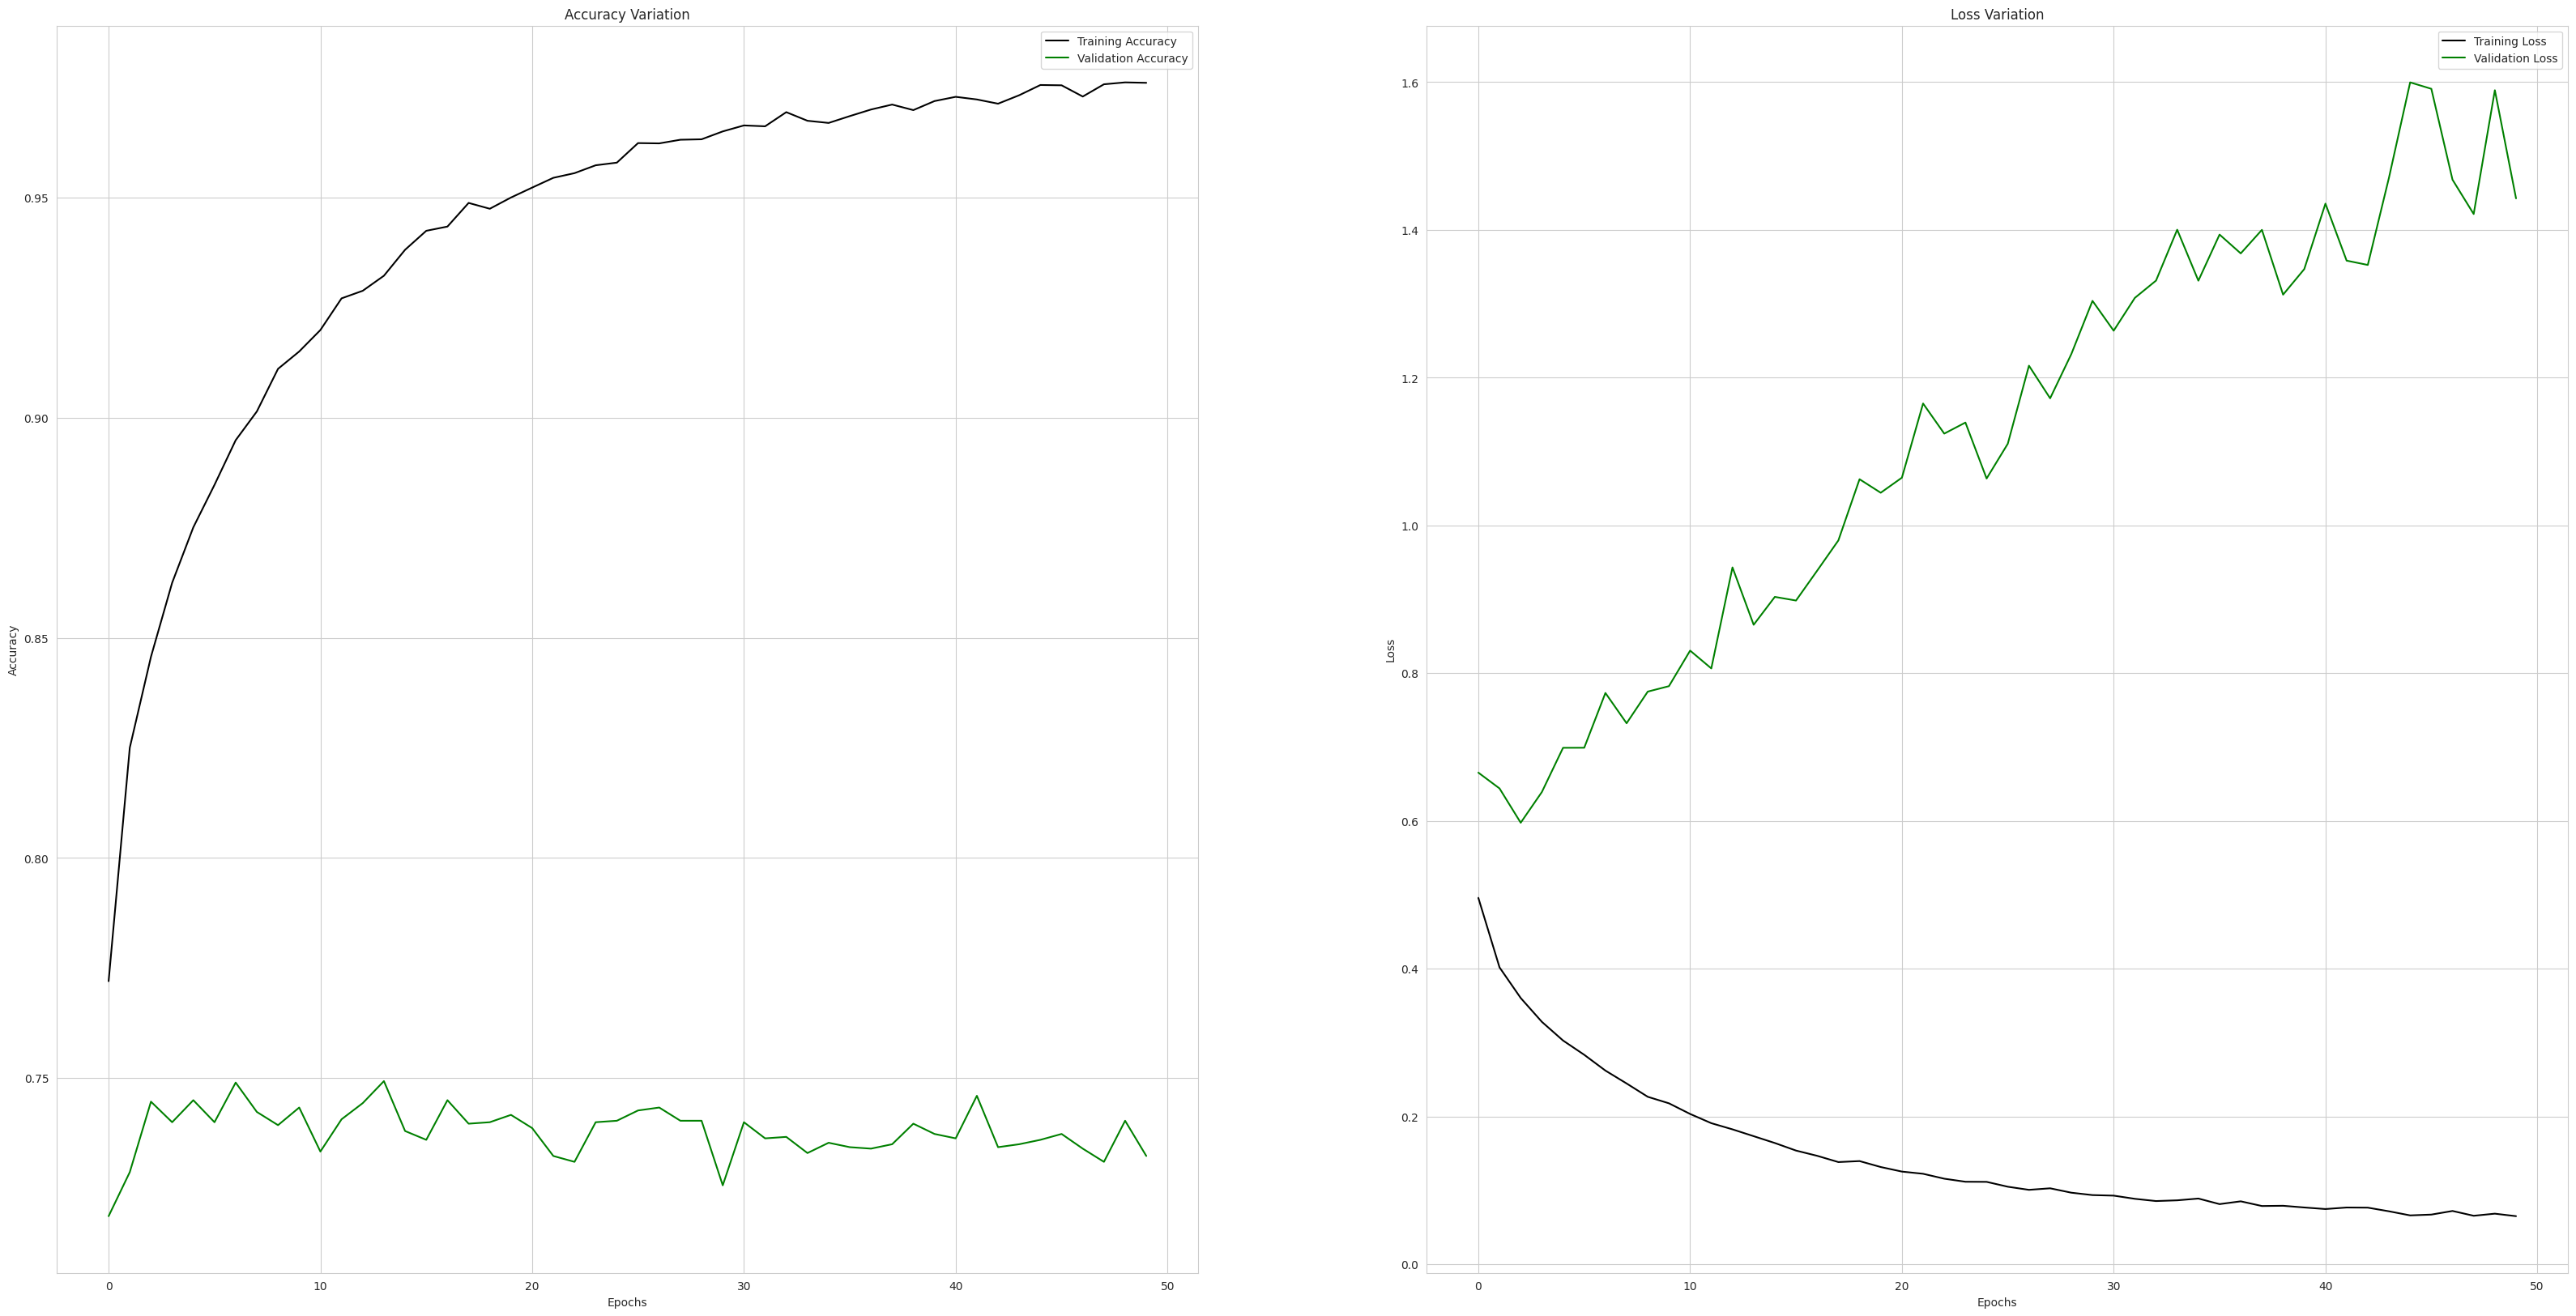

In [ ]:
fig,ax = plt.subplots(figsize = (40,20), ncols = 2)
ax[0].plot(history.history['accuracy'],color = 'black', label = 'Training Accuracy')
ax[0].plot(history.history['val_accuracy'],color = 'green', label = 'Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_title('Accuracy Variation')
ax[0].legend()

ax[1].plot(history.history['loss'],color = 'black', label = 'Training Loss')
ax[1].plot(history.history['val_loss'],color = 'green', label = 'Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_title('Loss Variation')
ax[1].legend()
plt.show()

In [ ]:
from sklearn.linear_model import SGDClassifier
model_8 = SGDClassifier(loss='log_loss', penalty='elasticnet', alpha=0.5, l1_ratio=0.5)
model_8.fit(X_train, y_train)

SGDClassifier(alpha=0.5, l1_ratio=0.5, loss='log_loss', penalty='elasticnet')

In [ ]:
y_pred_8 = model_8.predict(X_test)
metrics_8 = test_results(model_8, 5)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  labels to calculate F-beta score for.
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0

In [ ]:
model_list = {
    "XGBoost" : pd.Series(metrics_1),
    "Logistic_Regression" : pd.Series(metrics_2),
    "SVM_Linear" : pd.Series(metrics_3),
    "SVM_Polynomial" : pd.Series(metrics_4),
    "SVM_RBF" : pd.Series(metrics_5),
    "Random_Forest" : pd.Series(metrics_6),
    "ANN" : pd.Series(metrics_7),
    "SGD_Elastic_Net" : pd.Series(metrics_8),
}

pd.DataFrame(model_list).T


accuracy  precision_weighted  recall_weighted  \
XGBoost              0.764667            0.757476         0.764667   
Logistic_Regression  0.710000            0.694786         0.710000   
SVM_Linear           0.705000            0.686908         0.705000   
SVM_Polynomial       0.688000            0.676663         0.688000   
SVM_RBF              0.730333            0.720001         0.730333   
Random_Forest        0.763000            0.758152         0.763000   
ANN                  0.753000            0.760060         0.753000   
SGD_Elastic_Net      0.666667            0.444444         0.666667   

                     f1_weighted  
XGBoost                 0.757317  
Logistic_Regression     0.694052  
SVM_Linear              0.679617  
SVM_Polynomial          0.613655  
SVM_RBF                 0.703784  
Random_Forest           0.745409  
ANN                     0.721364  
SGD_Elastic_Net         0.533333

<ipython-input-153-348da9139f1a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')


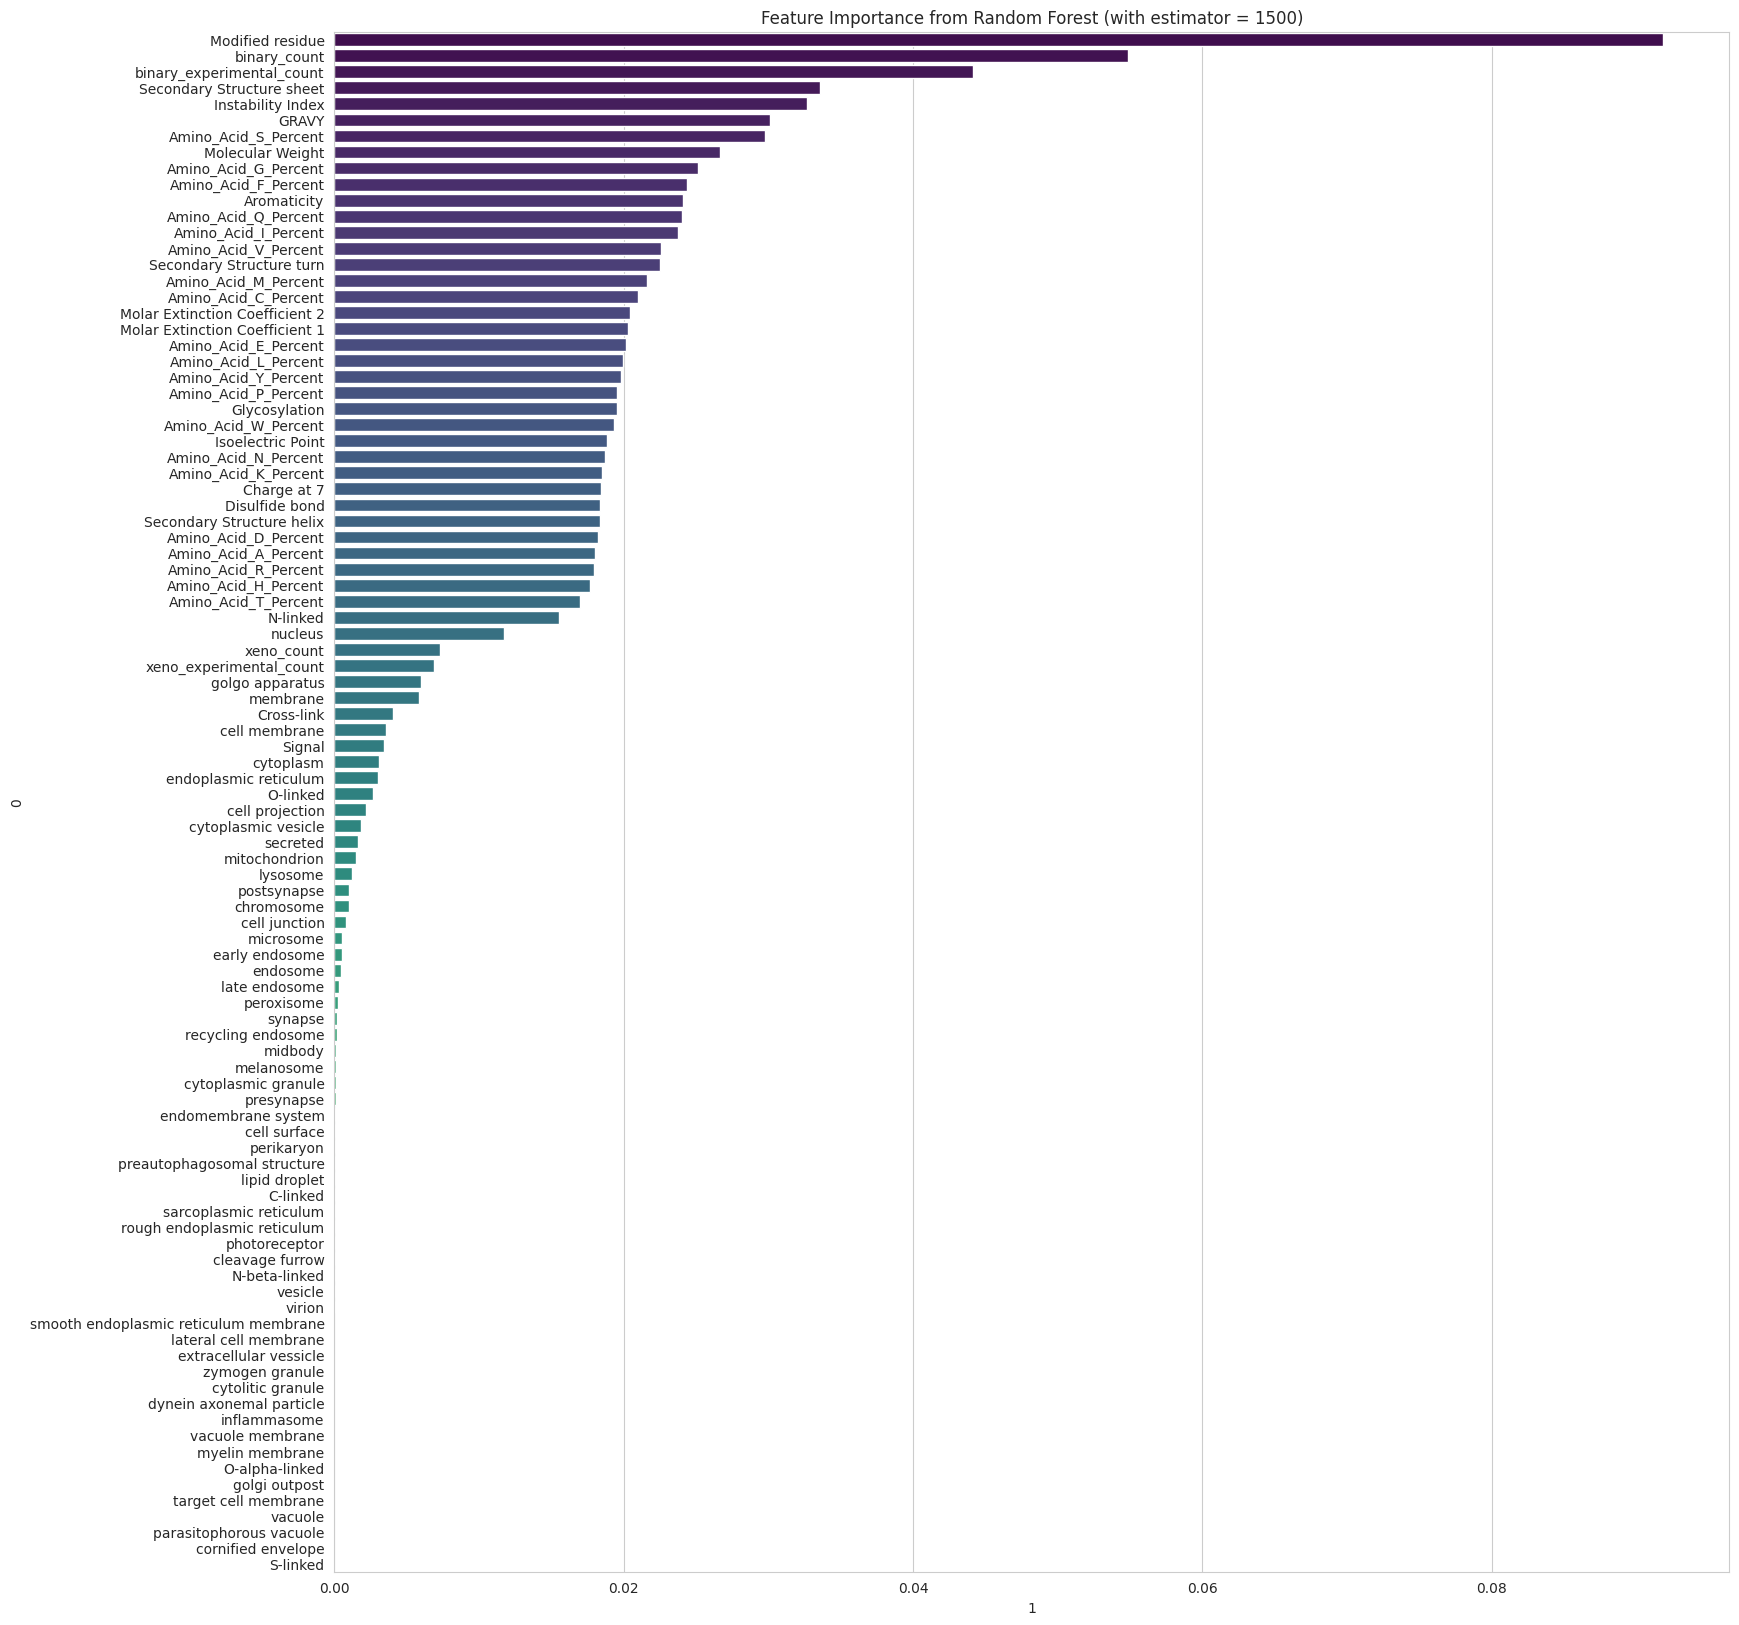

In [ ]:
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
plt.figure(figsize=(18, 20))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

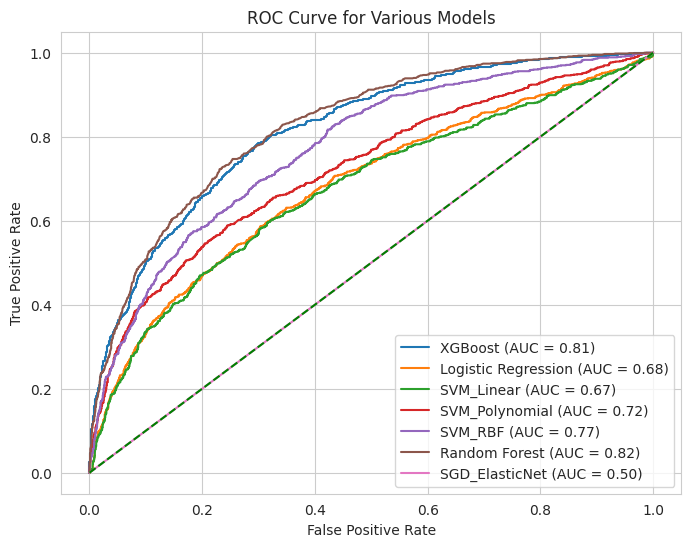

In [ ]:
#roc-auc curve for various algorithm
fpr_1, tpr_1, _ = roc_curve(y_test, model_1.predict_proba(X_test)[:, 1])
fpr_2, tpr_2, _ = roc_curve(y_test, model_2.predict_proba(X_test)[:, 1])
fpr_3, tpr_3, _ = roc_curve(y_test, model_3.predict_proba(X_test)[:, 1])
fpr_4, tpr_4, _ = roc_curve(y_test, model_4.predict_proba(X_test)[:, 1])
fpr_5, tpr_5, _ = roc_curve(y_test, model_5.predict_proba(X_test)[:, 1])
fpr_6, tpr_6, _ = roc_curve(y_test, model_6.predict_proba(X_test)[:, 1])
fpr_8, tpr_8, _ = roc_curve(y_test, model_8.predict_proba(X_test)[:, 1])

from sklearn.metrics import roc_auc_score

auc_1 = roc_auc_score(y_test, model_1.predict_proba(X_test)[:, 1])
auc_2 = roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1])
auc_3 = roc_auc_score(y_test, model_3.predict_proba(X_test)[:, 1])
auc_4 = roc_auc_score(y_test, model_4.predict_proba(X_test)[:, 1])
auc_5 = roc_auc_score(y_test, model_5.predict_proba(X_test)[:, 1])
auc_6 = roc_auc_score(y_test, model_6.predict_proba(X_test)[:, 1])
auc_8 = roc_auc_score(y_test, model_8.predict_proba(X_test)[:, 1])

# Plot ROC curves for each model with AUC values in the legend
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label=f'XGBoost (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot(fpr_3, tpr_3, label=f'SVM_Linear (AUC = {auc_3:.2f})')
plt.plot(fpr_4, tpr_4, label=f'SVM_Polynomial (AUC = {auc_4:.2f})')
plt.plot(fpr_5, tpr_5, label=f'SVM_RBF (AUC = {auc_5:.2f})')
plt.plot(fpr_6, tpr_6, label=f'Random Forest (AUC = {auc_6:.2f})')
plt.plot(fpr_8, tpr_8, label=f'SGD_ElasticNet (AUC = {auc_8:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend()
plt.show()

In [ ]:
import pycaret
pycaret.__version__

'3.3.2'

In [ ]:
from pycaret.classification import *
setup(data = x_sample, target = y_sample, session_id = 123)
best_models = compare_models()

Processing:   0%|          | 0/65 [00:00<?, ?it/s]

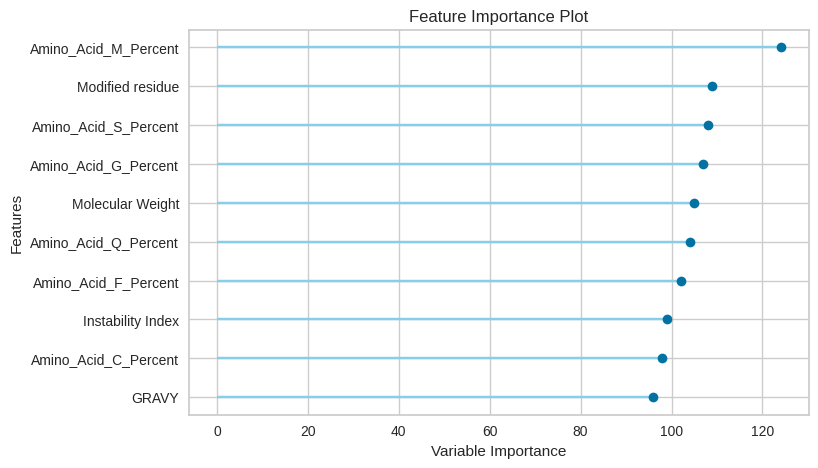

In [ ]:
plot_model(best_models, plot = 'feature')

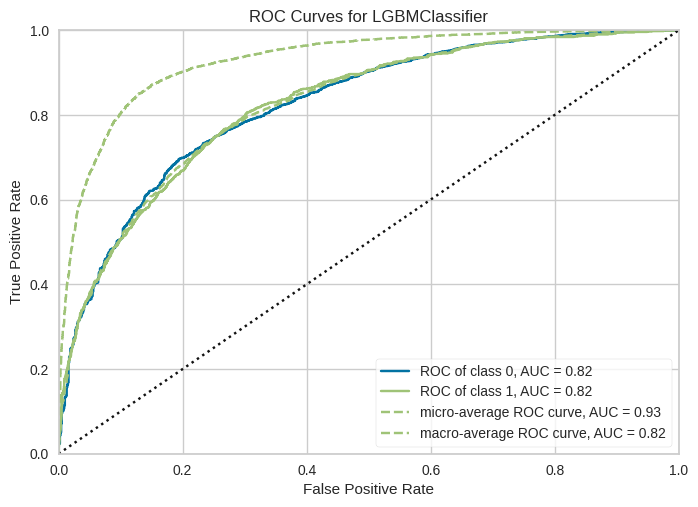

In [ ]:
plot_model(best_models, plot = 'auc')

K-old Cross Validation (5 folds)

In [ ]:
#using model_1 - XGBoost Classifier
from sklearn.model_selection import KFold

x_sample.reset_index(drop=True, inplace=True)

kf = KFold(n_splits=5)

precision = {
    "XGBoost" : [],
    "Logistic_Regression" : [],
    'SVM_Linear' : [],
    'SVM_Poly' : [],
    'SVM_RBF' : [],
    'Random_Forest' : [],
    'ANN' : [],

}
recall = {
    "XGBoost" : [],
    "Logistic_Regression" : [],
    'SVM_Linear' : [],
    'SVM_Poly' : [],
    'SVM_RBF' : [],
    'Random_Forest' : [],
    'ANN' : [],

}
f1 = {
    "XGBoost" : [],
    "Logistic_Regression" : [],
    'SVM_Linear' : [],
    'SVM_Poly' : [],
    'SVM_RBF' : [],
    'Random_Forest' : [],
    'ANN' : [],

}
accuracy = {
    "XGBoost" : [],
    "Logistic_Regression" : [],
    'SVM_Linear' : [],
    'SVM_Poly' : [],
    'SVM_RBF' : [],
    'Random_Forest' : [],
    'ANN' : [],
}

for fold, (train_index, test_index) in enumerate(kf.split(x_sample)):
    X_train = x_sample.loc[train_index]
    y_train = y_sample[train_index]
    X_test = x_sample.loc[test_index]
    y_test = y_sample[test_index]

    sc = StandardScaler()
    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    #for xgboost
    model_1 = xgboost.XGBClassifier()
    model_1.fit(X_train, y_train)
    y_pred = model_1.predict(X_test)
    precision['XGBoost'].append(precision_score(y_test, y_pred))
    recall['XGBoost'].append(recall_score(y_test, y_pred))
    f1['XGBoost'].append(f1_score(y_test, y_pred))
    accuracy['XGBoost'].append(accuracy_score(y_test, y_pred))

    #for logistic_regression
    model_2 = LogisticRegression()
    model_2.fit(X_train, y_train)
    y_pred = model_2.predict(X_test)
    precision['Logistic_Regression'].append(precision_score(y_test, y_pred))
    recall['Logistic_Regression'].append(recall_score(y_test, y_pred))
    f1['Logistic_Regression'].append(f1_score(y_test, y_pred))
    accuracy['Logistic_Regression'].append(accuracy_score(y_test, y_pred))

    #for svm linear kernel
    model_3 = svm.SVC(kernel = 'linear',probability = True)
    model_3.fit(X_train, y_train)
    y_pred = model_3.predict(X_test)
    precision['SVM_Linear'].append(precision_score(y_test, y_pred))
    recall['SVM_Linear'].append(recall_score(y_test, y_pred))
    f1['SVM_Linear'].append(f1_score(y_test, y_pred))
    accuracy['SVM_Linear'].append(accuracy_score(y_test, y_pred))

    #for svm polynomial kernel
    model_4 = svm.SVC(kernel = 'poly',probability = True)
    model_4.fit(X_train, y_train)
    y_pred = model_4.predict(X_test)
    precision['SVM_Poly'].append(precision_score(y_test, y_pred))
    recall['SVM_Poly'].append(recall_score(y_test, y_pred))
    f1['SVM_Poly'].append(f1_score(y_test, y_pred))
    accuracy['SVM_Poly'].append(accuracy_score(y_test, y_pred))

    #for svm RBF kernel
    model_5 = svm.SVC(kernel = 'rbf',probability = True)
    model_5.fit(X_train, y_train)
    y_pred = model_5.predict(X_test)
    precision['SVM_RBF'].append(precision_score(y_test, y_pred))
    recall['SVM_RBF'].append(recall_score(y_test, y_pred))
    f1['SVM_RBF'].append(f1_score(y_test, y_pred))
    accuracy['SVM_RBF'].append(accuracy_score(y_test, y_pred))

    #for random forest
    model_6 = RandomForestClassifier(n_estimators = 1500, criterion = 'entropy', random_state = 42)
    model_6.fit(X_train, y_train)
    y_pred = model_6.predict(X_test)
    precision['Random_Forest'].append(precision_score(y_test, y_pred))
    recall['Random_Forest'].append(recall_score(y_test, y_pred))
    f1['Random_Forest'].append(f1_score(y_test, y_pred))
    accuracy['Random_Forest'].append(accuracy_score(y_test, y_pred))

    #for ann model
    model_7.fit(X_train, y_train, validation_data = (X_test,y_test), epochs = 50)
    y_pred = model_7.predict(X_test)
    y_pred = (y_pred >= 0.5).astype(int)
    precision['ANN'].append(precision_score(y_test, y_pred))
    recall['ANN'].append(recall_score(y_test, y_pred))
    f1['ANN'].append(f1_score(y_test, y_pred))
    accuracy['ANN'].append(accuracy_score(y_test, y_pred))


metrics_1 = {
    "accuracy" :  sum(accuracy['XGBoost'])/len(accuracy['XGBoost']),
    "precision" : sum(precision['XGBoost'])/len(precision['XGBoost']),
    "recall" :  sum(recall['XGBoost'])/len(recall['XGBoost']),
    "f1_score" : sum(f1['XGBoost'])/len(f1['XGBoost']),
}

metrics_2 = {
    "accuracy" :  sum(accuracy['Logistic_Regression'])/len(accuracy['Logistic_Regression']),
    "precision" : sum(precision['Logistic_Regression'])/len(precision['Logistic_Regression']),
    "recall" :  sum(recall['Logistic_Regression'])/len(recall['Logistic_Regression']),
    "f1_score" : sum(f1['Logistic_Regression'])/len(f1['Logistic_Regression']),
}

metrics_3 = {
    "accuracy" :  sum(accuracy['SVM_Linear'])/len(accuracy['SVM_Linear']),
    "precision" : sum(precision['SVM_Linear'])/len(precision['SVM_Linear']),
    "recall" :  sum(recall['SVM_Linear'])/len(recall['SVM_Linear']),
    "f1_score" : sum(f1['SVM_Linear'])/len(f1['SVM_Linear']),
}

metrics_4 = {
    "accuracy" :  sum(accuracy['SVM_Poly'])/len(accuracy['SVM_Poly']),
    "precision" : sum(precision['SVM_Poly'])/len(precision['SVM_Poly']),
    "recall" :  sum(recall['SVM_Poly'])/len(recall['SVM_Poly']),
    "f1_score" : sum(f1['SVM_Poly'])/len(f1['SVM_Poly']),
}

metrics_5 = {
    "accuracy" :  sum(accuracy['SVM_RBF'])/len(accuracy['SVM_RBF']),
    "precision" : sum(precision['SVM_RBF'])/len(precision['SVM_RBF']),
    "recall" :  sum(recall['SVM_RBF'])/len(recall['SVM_RBF']),
    "f1_score" : sum(f1['SVM_RBF'])/len(f1['SVM_RBF']),
}

metrics_6 = {
    "accuracy" :  sum(accuracy['Random_Forest'])/len(accuracy['Random_Forest']),
    "precision" : sum(precision['Random_Forest'])/len(precision['Random_Forest']),
    "recall" :  sum(recall['Random_Forest'])/len(recall['Random_Forest']),
    "f1_score" : sum(f1['Random_Forest'])/len(f1['Random_Forest']),
}

metrics_7 = {
    "accuracy" :  sum(accuracy['ANN'])/len(accuracy['ANN']),
    "precision" : sum(precision['ANN'])/len(precision['ANN']),
    "recall" :  sum(recall['ANN'])/len(recall['ANN']),
    "f1_score" : sum(f1['ANN'])/len(f1['ANN']),
}



model_list = {
    "XGBoost" : pd.Series(metrics_1),
    "Logistic_Regression" : pd.Series(metrics_2),
    "SVM_Linear" : pd.Series(metrics_3),
    "SVM_Polynomial" : pd.Series(metrics_4),
    "SVM_RBF" : pd.Series(metrics_5),
    "Random_Forest" : pd.Series(metrics_6),
    "ANN" : pd.Series(metrics_7),
}

pd.DataFrame(model_list).T

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x789734ab2440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 1175, in _make_controller_from_path
    lib_controller = controller_class(
  File "/usr/local/lib/python3.10/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
  File "/usr/lib/python3.10/ctypes/__init__.py", line 374, in __init__
    self._handle = _dlopen(self._name, mode)
OSError: dlopen() error
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of i

Epoch 1/50
917/917 [==============================] - 4s 3ms/step - loss: 0.4906 - accuracy: 0.7774 - val_loss: 0.8071 - val_accuracy: 0.6619
Epoch 2/50
917/917 [==============================] - 3s 3ms/step - loss: 0.3957 - accuracy: 0.8307 - val_loss: 0.8006 - val_accuracy: 0.6672
Epoch 3/50
917/917 [==============================] - 4s 4ms/step - loss: 0.3505 - accuracy: 0.8518 - val_loss: 0.7790 - val_accuracy: 0.6770
Epoch 4/50
917/917 [==============================] - 3s 3ms/step - loss: 0.3107 - accuracy: 0.8723 - val_loss: 0.7901 - val_accuracy: 0.6831
Epoch 5/50
917/917 [==============================] - 3s 3ms/step - loss: 0.2843 - accuracy: 0.8858 - val_loss: 0.8483 - val_accuracy: 0.6736
Epoch 6/50
917/917 [==============================] - 3s 3ms/step - loss: 0.2574 - accuracy: 0.8962 - val_loss: 0.9256 - val_accuracy: 0.6694
Epoch 7/50
917/917 [==============================] - 3s 3ms/step - loss: 0.2338 - accuracy: 0.9073 - val_loss: 0.9261 - val_accuracy: 0.6667
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  method="L-BFGS-B",


Epoch 1/50
868/868 [==============================] - 3s 3ms/step - loss: 0.3566 - accuracy: 0.8585 - val_loss: 0.2977 - val_accuracy: 0.8897
Epoch 2/50
868/868 [==============================] - 2s 3ms/step - loss: 0.2616 - accuracy: 0.8943 - val_loss: 0.2658 - val_accuracy: 0.8987
Epoch 3/50
868/868 [==============================] - 4s 4ms/step - loss: 0.2321 - accuracy: 0.9076 - val_loss: 0.3368 - val_accuracy: 0.8561
Epoch 4/50
868/868 [==============================] - 3s 3ms/step - loss: 0.2089 - accuracy: 0.9180 - val_loss: 0.3225 - val_accuracy: 0.8708
Epoch 5/50
868/868 [==============================] - 2s 3ms/step - loss: 0.1925 - accuracy: 0.9247 - val_loss: 0.3642 - val_accuracy: 0.8520
Epoch 6/50
868/868 [==============================] - 3s 3ms/step - loss: 0.1723 - accuracy: 0.9338 - val_loss: 0.4009 - val_accuracy: 0.8532
Epoch 7/50
868/868 [==============================] - 2s 3ms/step - loss: 0.1622 - accuracy: 0.9380 - val_loss: 0.4275 - val_accuracy: 0.8402
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  method="L-BFGS-B",


Epoch 1/50
838/838 [==============================] - 3s 4ms/step - loss: 0.2355 - accuracy: 0.9182 - val_loss: 0.1472 - val_accuracy: 0.9638
Epoch 2/50
838/838 [==============================] - 2s 3ms/step - loss: 0.1575 - accuracy: 0.9422 - val_loss: 0.1385 - val_accuracy: 0.9606
Epoch 3/50
838/838 [==============================] - 2s 3ms/step - loss: 0.1407 - accuracy: 0.9472 - val_loss: 0.1365 - val_accuracy: 0.9594
Epoch 4/50
838/838 [==============================] - 2s 3ms/step - loss: 0.1291 - accuracy: 0.9507 - val_loss: 0.1446 - val_accuracy: 0.9545
Epoch 5/50
838/838 [==============================] - 2s 3ms/step - loss: 0.1206 - accuracy: 0.9551 - val_loss: 0.1233 - val_accuracy: 0.9579
Epoch 6/50
838/838 [==============================] - 3s 4ms/step - loss: 0.1088 - accuracy: 0.9581 - val_loss: 0.2080 - val_accuracy: 0.9327
Epoch 7/50
838/838 [==============================] - 3s 4ms/step - loss: 0.0989 - accuracy: 0.9623 - val_loss: 0.1609 - val_accuracy: 0.9396
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  method="L-BFGS-B",


Epoch 1/50
837/837 [==============================] - 3s 4ms/step - loss: 0.1651 - accuracy: 0.9446 - val_loss: 0.0783 - val_accuracy: 0.9785
Epoch 2/50
837/837 [==============================] - 3s 4ms/step - loss: 0.1009 - accuracy: 0.9627 - val_loss: 0.0926 - val_accuracy: 0.9697
Epoch 3/50
837/837 [==============================] - 2s 3ms/step - loss: 0.0885 - accuracy: 0.9679 - val_loss: 0.0882 - val_accuracy: 0.9701
Epoch 4/50
837/837 [==============================] - 2s 3ms/step - loss: 0.0819 - accuracy: 0.9699 - val_loss: 0.1042 - val_accuracy: 0.9679
Epoch 5/50
837/837 [==============================] - 2s 3ms/step - loss: 0.0729 - accuracy: 0.9746 - val_loss: 0.1013 - val_accuracy: 0.9721
Epoch 6/50
837/837 [==============================] - 2s 3ms/step - loss: 0.0693 - accuracy: 0.9743 - val_loss: 0.0892 - val_accuracy: 0.9699
Epoch 7/50
837/837 [==============================] - 3s 4ms/step - loss: 0.0688 - accuracy: 0.9736 - val_loss: 0.1503 - val_accuracy: 0.9530
Epoch 

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  method="L-BFGS-B",


Epoch 1/50
815/815 [==============================] - 3s 4ms/step - loss: 0.1326 - accuracy: 0.9565 - val_loss: 0.0540 - val_accuracy: 0.9865
Epoch 2/50
815/815 [==============================] - 2s 3ms/step - loss: 0.0821 - accuracy: 0.9714 - val_loss: 0.0378 - val_accuracy: 0.9927
Epoch 3/50
815/815 [==============================] - 2s 3ms/step - loss: 0.0681 - accuracy: 0.9751 - val_loss: 0.0365 - val_accuracy: 0.9939
Epoch 4/50
815/815 [==============================] - 2s 3ms/step - loss: 0.0617 - accuracy: 0.9766 - val_loss: 0.0442 - val_accuracy: 0.9895
Epoch 5/50
815/815 [==============================] - 2s 3ms/step - loss: 0.0581 - accuracy: 0.9783 - val_loss: 0.0338 - val_accuracy: 0.9941
Epoch 6/50
815/815 [==============================] - 3s 4ms/step - loss: 0.0564 - accuracy: 0.9790 - val_loss: 0.0496 - val_accuracy: 0.9924
Epoch 7/50
815/815 [==============================] - 3s 4ms/step - loss: 0.0543 - accuracy: 0.9809 - val_loss: 0.0502 - val_accuracy: 0.9873
Epoch 

accuracy  precision    recall  f1_score
XGBoost              0.831904   0.386981  0.330842  0.325838
Logistic_Regression  0.666485   0.248663  0.556529  0.304714
SVM_Linear           0.645244   0.245335  0.583923  0.303048
SVM_Polynomial       0.608592   0.233611  0.655348  0.305254
SVM_RBF              0.758494   0.297902  0.527216  0.335143
Random_Forest        0.834988   0.387833  0.331169  0.342434
ANN                  0.855834   0.494931  0.626647  0.507180

<ipython-input-39-348da9139f1a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')


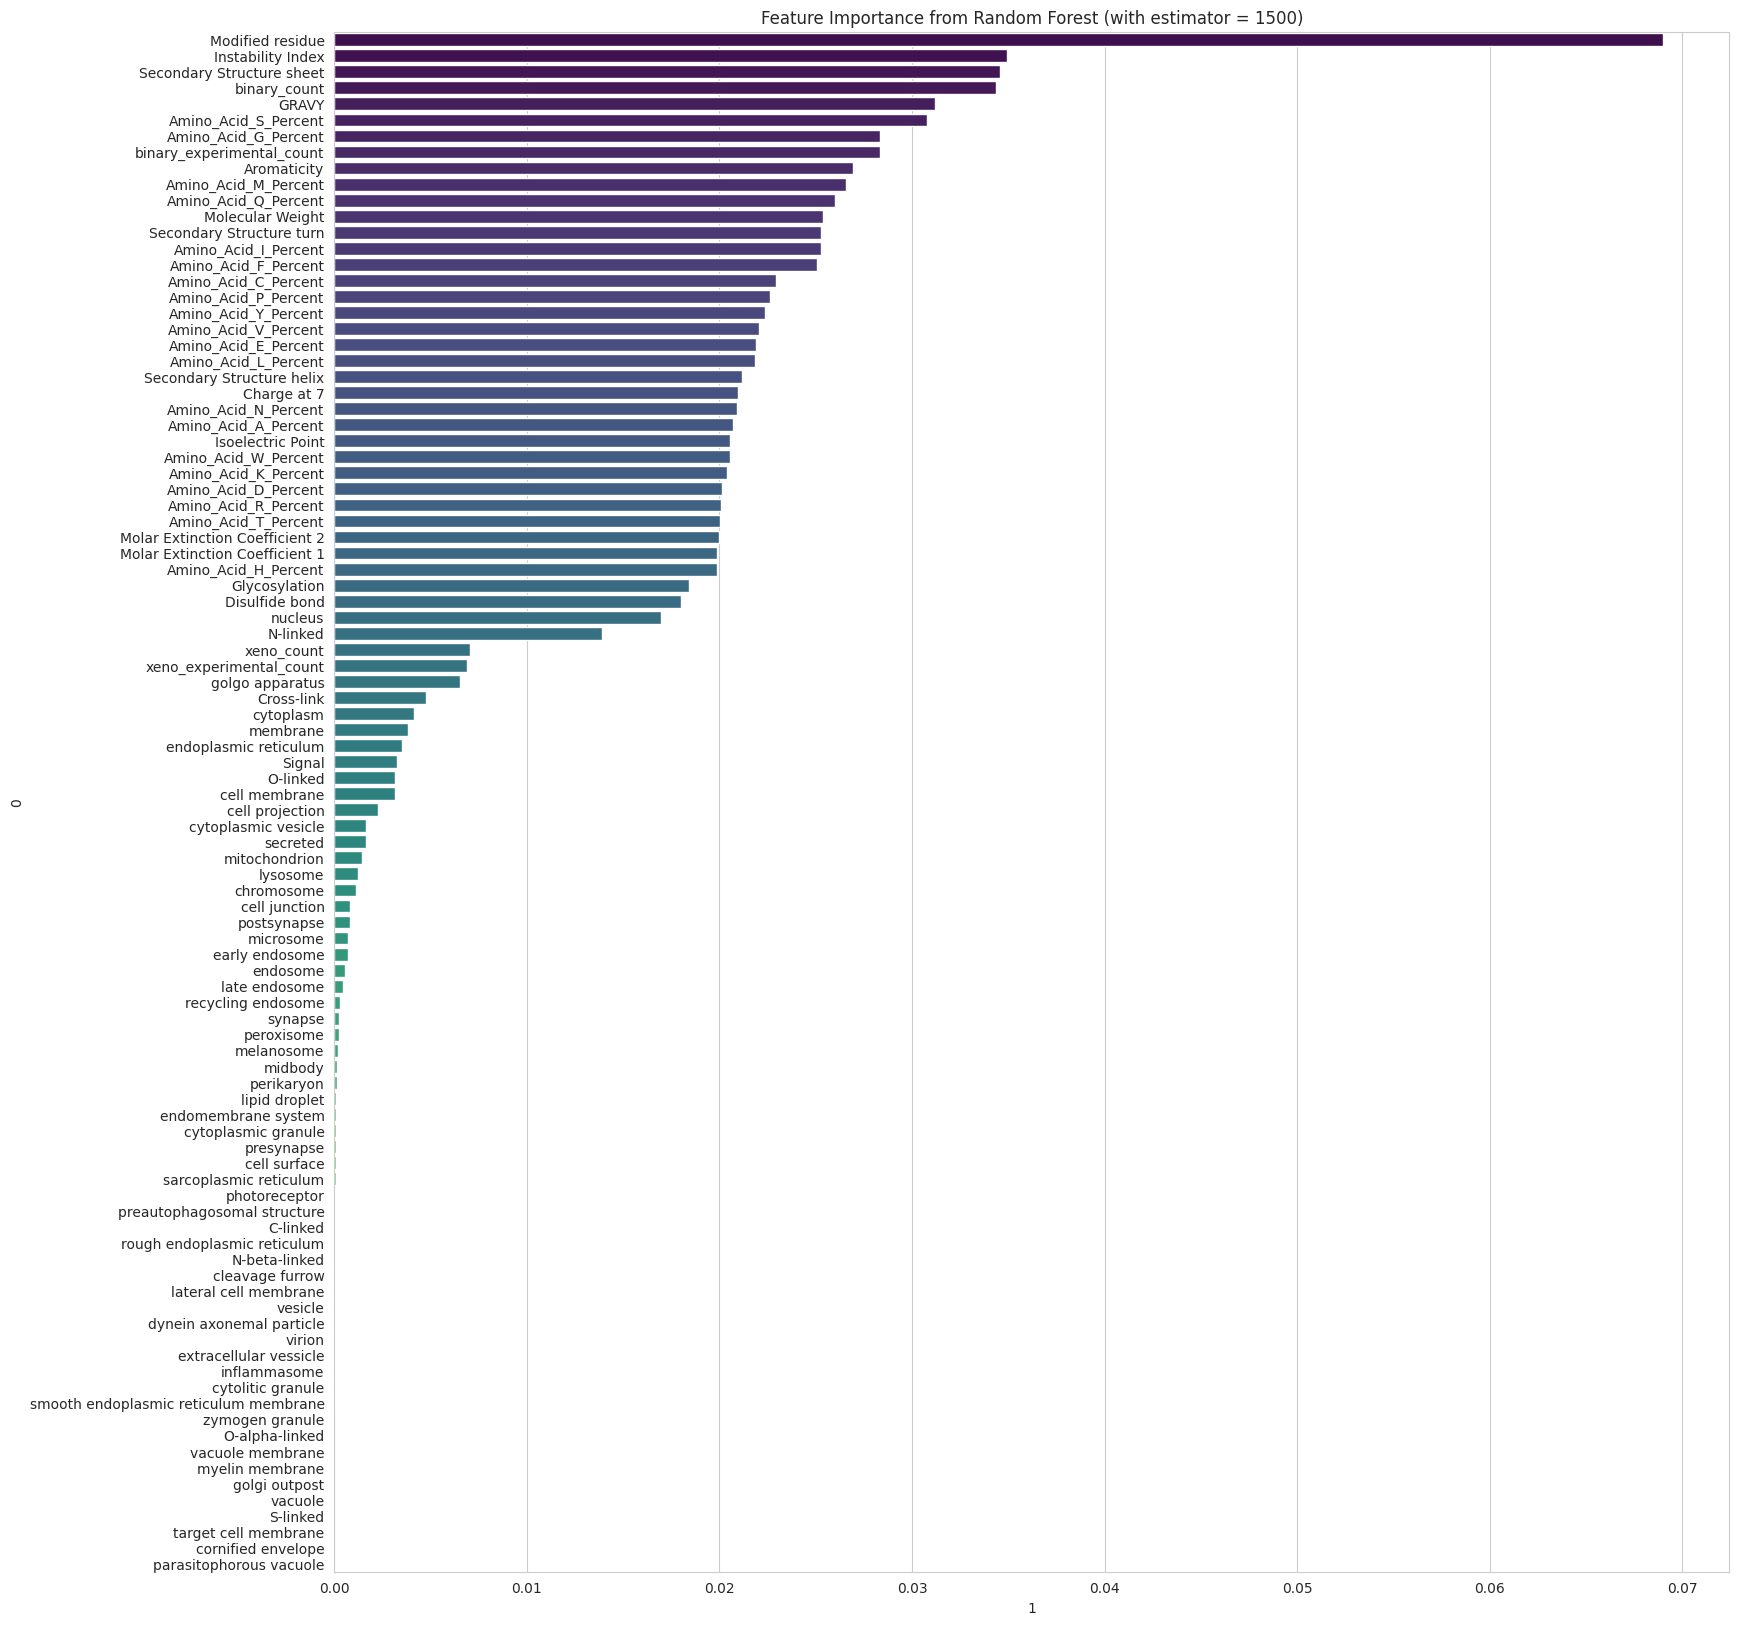

In [ ]:
feature_importance = model_6.feature_importances_
okk = pd.DataFrame([x_sample.columns, feature_importance]).T
okk = okk.sort_values(by = 1,ascending = False)
plt.figure(figsize=(18, 20))
sns.barplot(x = okk[1], y = okk[0], data = okk, palette='viridis')
plt.title("Feature Importance from Random Forest (with estimator = 1500)")
plt.show()

cell surface                0.000000
dynein axonemal particle    0.000000
golgi outpost               0.000000
vacuole membrane            0.000000
lateral cell membrane       0.000000
                              ...   
golgo apparatus             0.031051
Disulfide bond              0.032734
cell membrane               0.041461
microsome                   0.044030
Modified residue            0.053035
Length: 96, dtype: float32


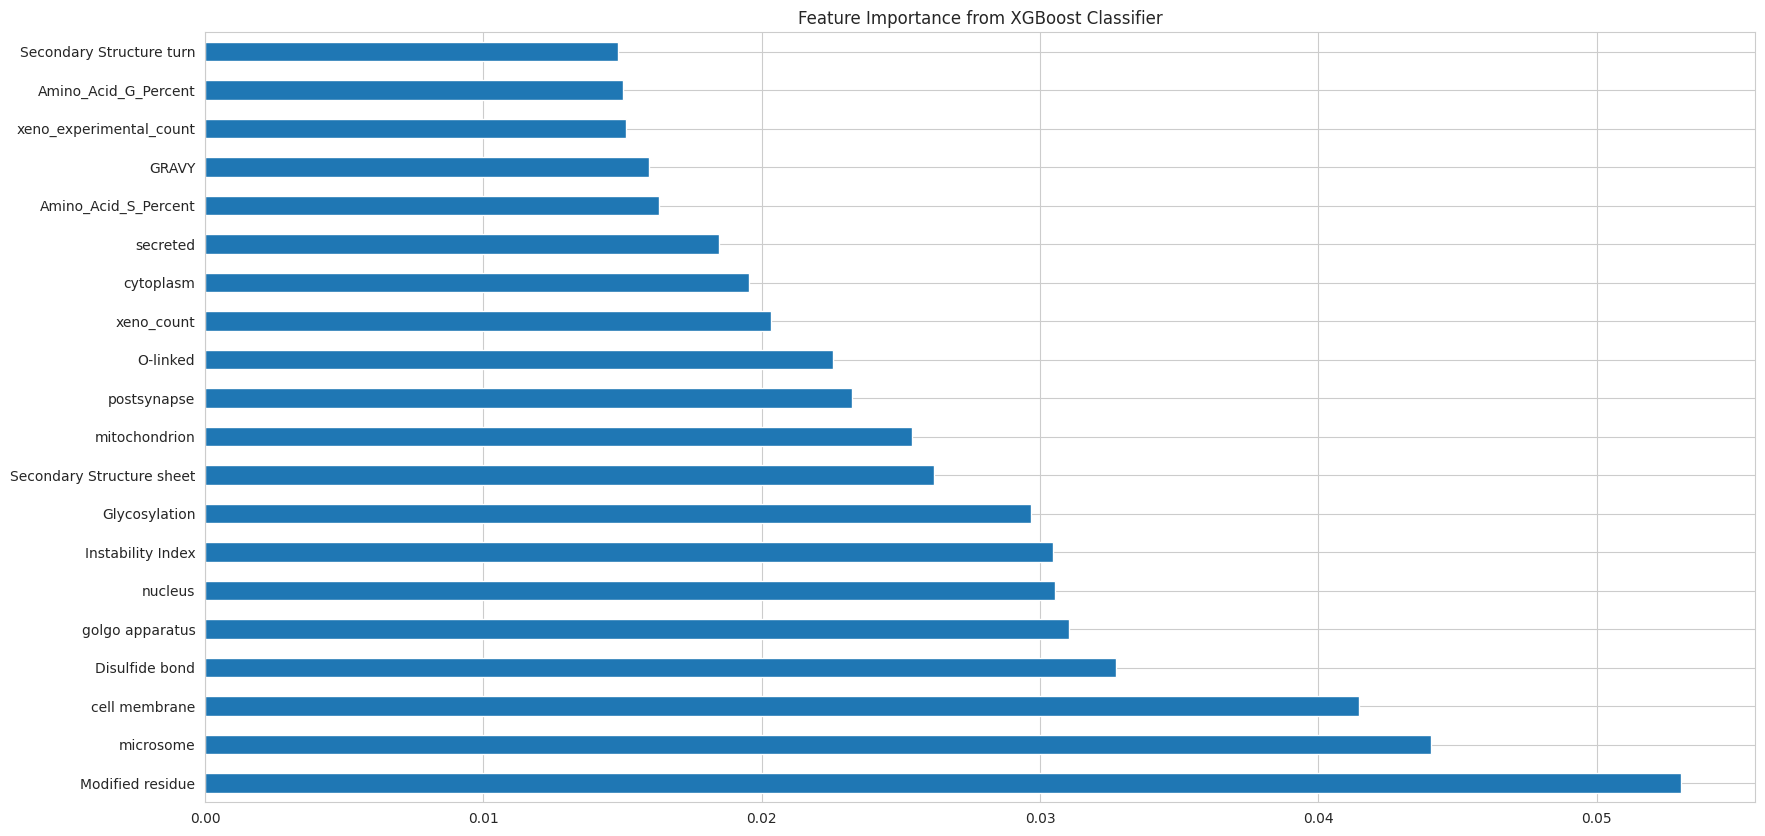

In [ ]:
feat_imp = pd.Series(model.feature_importances_, index=x_sample.columns)
print(feat_imp.sort_values())
feat_imp.nlargest(20).plot(kind='barh',figsize=(20,10))
plt.title('Feature Importance from XGBoost Classifier')
plt.show()

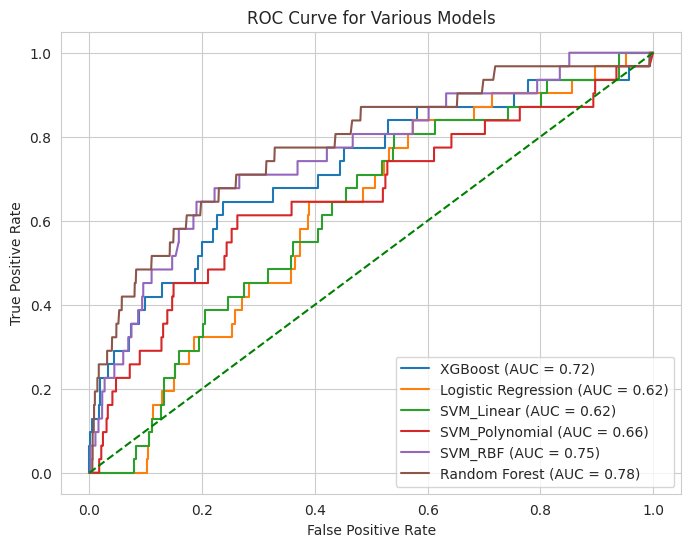

In [ ]:
#roc-auc curve for various algorithm
fpr_1, tpr_1, _ = roc_curve(y_test, model_1.predict_proba(X_test)[:, 1])
fpr_2, tpr_2, _ = roc_curve(y_test, model_2.predict_proba(X_test)[:, 1])
fpr_3, tpr_3, _ = roc_curve(y_test, model_3.predict_proba(X_test)[:, 1])
fpr_4, tpr_4, _ = roc_curve(y_test, model_4.predict_proba(X_test)[:, 1])
fpr_5, tpr_5, _ = roc_curve(y_test, model_5.predict_proba(X_test)[:, 1])
fpr_6, tpr_6, _ = roc_curve(y_test, model_6.predict_proba(X_test)[:, 1])

from sklearn.metrics import roc_auc_score

auc_1 = roc_auc_score(y_test, model_1.predict_proba(X_test)[:, 1])
auc_2 = roc_auc_score(y_test, model_2.predict_proba(X_test)[:, 1])
auc_3 = roc_auc_score(y_test, model_3.predict_proba(X_test)[:, 1])
auc_4 = roc_auc_score(y_test, model_4.predict_proba(X_test)[:, 1])
auc_5 = roc_auc_score(y_test, model_5.predict_proba(X_test)[:, 1])
auc_6 = roc_auc_score(y_test, model_6.predict_proba(X_test)[:, 1])

# Plot ROC curves for each model with AUC values in the legend
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, label=f'XGBoost (AUC = {auc_1:.2f})')
plt.plot(fpr_2, tpr_2, label=f'Logistic Regression (AUC = {auc_2:.2f})')
plt.plot(fpr_3, tpr_3, label=f'SVM_Linear (AUC = {auc_3:.2f})')
plt.plot(fpr_4, tpr_4, label=f'SVM_Polynomial (AUC = {auc_4:.2f})')
plt.plot(fpr_5, tpr_5, label=f'SVM_RBF (AUC = {auc_5:.2f})')
plt.plot(fpr_6, tpr_6, label=f'Random Forest (AUC = {auc_6:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], color='green', linestyle='--')

# Set labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Various Models')
plt.legend()
plt.show()